## Data preprocessing

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime

# ÏÉòÌîåÎßÅ Í∞ÑÍ≤© (Î∂Ñ)
SAMPLING_INTERVALS = {
    "12": 5,
    "16": 5,
    "17": 5,
    "21": 360
}
SOURCE_LABELS = {
    "12": "Light",
    "16": "Connectivity",
    "17": "Battery",
    "21": "Permission"
}
EIGHT_WEEKS_MINUTES = 8 * 7 * 24 * 60  # 8Ï£º

# timestamp Ï∂îÏ∂ú
def extract_timestamps_from_file(file_path):
    try:
        df = pd.read_csv(file_path)
        if df.empty or "timestamp" not in df.columns or df["timestamp"].dropna().empty:
            return []
        timestamps_dt = pd.to_datetime(df["timestamp"], errors="coerce").dropna()
        return timestamps_dt.tolist()
    except Exception as e:
        print(f"‚ùå Error parsing {file_path}: {e}")
        return []

# ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞
def compute_final_missing(timestamps_dt, interval_minutes):
    timestamps_dt.sort()
    start_time = min(timestamps_dt)
    end_time = max(timestamps_dt)
    duration_minutes = (end_time - start_time).total_seconds() / 60

    # Í≥†Ïú†Ìïú 5Î∂Ñ Îã®ÏúÑÎ°ú floorÌïú timestamp Ïàò
    timestamps_5min = set(pd.Series(timestamps_dt).dt.floor(f"{interval_minutes}min"))
    actual_count = len(timestamps_5min)

    expected_count = int(duration_minutes // interval_minutes) + 1
    if actual_count > expected_count:
        actual_count = expected_count

    if duration_minutes < EIGHT_WEEKS_MINUTES:
        perfect = int(EIGHT_WEEKS_MINUTES // interval_minutes)
    else:
        perfect = expected_count

    missing = max(0, perfect - actual_count)
    missing_percent = (missing / perfect) * 100 if perfect > 0 else 0.0

    return start_time, end_time, round(missing_percent, 2), actual_count, perfect

# Í≤ΩÎ°ú ÏÑ§Ï†ï
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1", "Batch2"]

records = []

for batch in BATCHES:
    batch_path = BASE_PATH / batch
    if not batch_path.exists():
        continue

    for user_folder in batch_path.iterdir():
        if not user_folder.is_dir():
            continue
        user_id = user_folder.name

        for source_num, source_label in SOURCE_LABELS.items():
            file_path = user_folder / f"source_{source_num}" / f"data_source_{source_num}.csv"
            if not file_path.exists():
                continue

            timestamps_dt = extract_timestamps_from_file(file_path)

            if len(timestamps_dt) >= 1:
                start_dt, end_dt, missing_pct, actual, expected = compute_final_missing(
                    timestamps_dt, SAMPLING_INTERVALS[source_num]
                )
                start_str = start_dt.strftime("%Y-%m-%d %H:%M:%S")
                end_str = end_dt.strftime("%Y-%m-%d %H:%M:%S")
            else:
                start_str = end_str = ""
                missing_pct = 100.0
                actual = 0
                expected = int(EIGHT_WEEKS_MINUTES // SAMPLING_INTERVALS[source_num])

            records.append({
                "Batch": batch,
                "User": user_id,
                "Source": source_label,
                "StartDate": start_str,
                "EndDate": end_str,
                "Actual Samples": actual,
                "Expected Samples": expected,
                "Final Missing %": missing_pct
            })

# Ï†ÄÏû•
df = pd.DataFrame(records)
df.to_csv("final_corrected_missing_summary.csv", index=False)
print("‚úÖ ÏµúÏ¢Ö ÎàÑÎùΩÎ•† CSV Ï†ÄÏû• ÏôÑÎ£å ‚Üí missing_percentage_all_batches.csv")

‚úÖ ÏµúÏ¢Ö ÎàÑÎùΩÎ•† CSV Ï†ÄÏû• ÏôÑÎ£å ‚Üí missing_percentage_all_batches.csv


## Visualization

### ÏÑºÏÑúÎ≥Ñ ÌèâÍ∑† ÎàÑÎùΩÎ•† (Batch1 vs Batch2 ÎπÑÍµê)

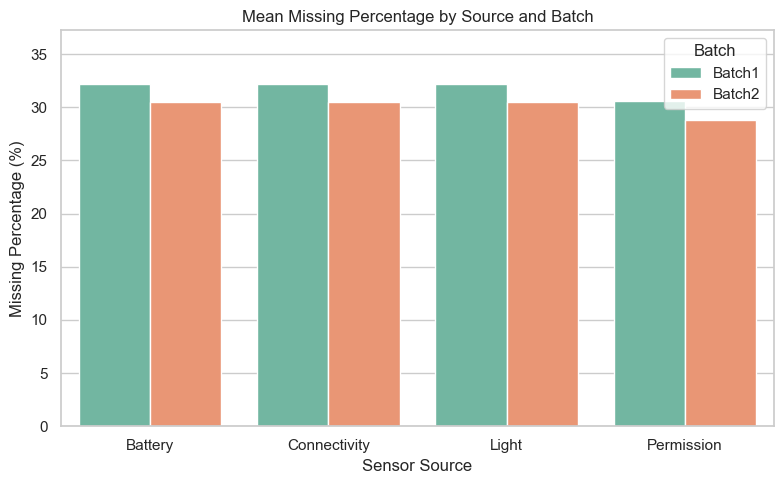

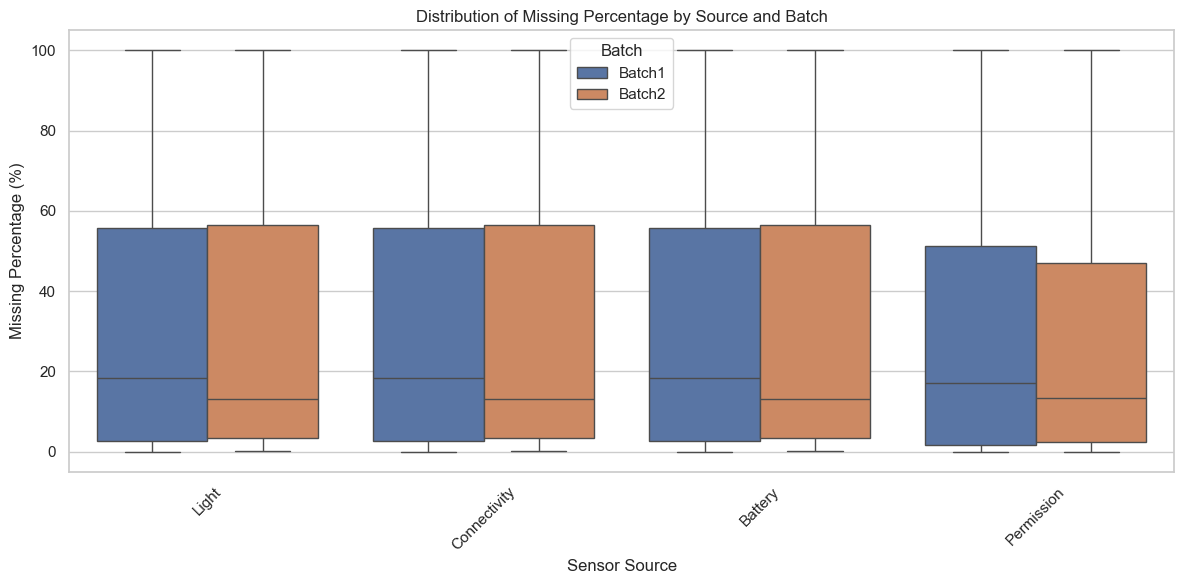

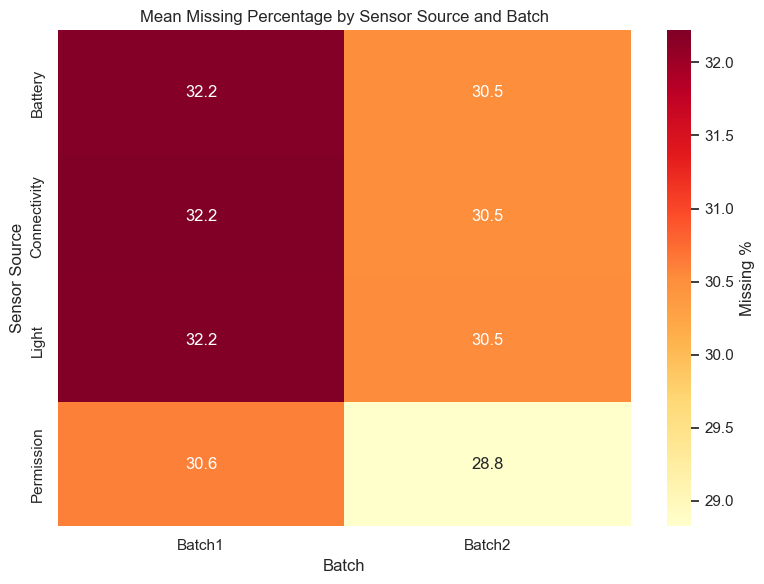


Descriptive Statistics by Source and Batch:

| Source       | Batch   |   count |   mean |   std |   min |   q25 |   median |   q75 |   max |
|:-------------|:--------|--------:|-------:|------:|------:|------:|---------:|------:|------:|
| Battery      | Batch1  |      66 |  32.19 | 35.08 |  0.04 |  2.64 |    18.4  | 55.66 |   100 |
| Battery      | Batch2  |     108 |  30.51 | 33.09 |  0.1  |  3.3  |    13.19 | 56.59 |   100 |
| Connectivity | Batch1  |      66 |  32.22 | 35.08 |  0.04 |  2.64 |    18.4  | 55.66 |   100 |
| Connectivity | Batch2  |     108 |  30.51 | 33.09 |  0.1  |  3.3  |    13.18 | 56.59 |   100 |
| Light        | Batch1  |      66 |  32.2  | 35.08 |  0.04 |  2.64 |    18.45 | 55.67 |   100 |
| Light        | Batch2  |     108 |  30.53 | 33.07 |  0.1  |  3.3  |    13.19 | 56.59 |   100 |
| Permission   | Batch1  |      66 |  30.61 | 35.15 |  0    |  1.78 |    17.12 | 51.34 |   100 |
| Permission   | Batch2  |     108 |  28.83 | 32.61 |  0    |  2.43 |    13.33 | 

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSV Î∂àÎü¨Ïò§Í∏∞ (Î≥¥Ï†ïÎêú ÎàÑÎùΩÎ•†Ïù¥ Ï†ÅÏö©Îêú Î≤ÑÏ†Ñ)
df = pd.read_csv("final_corrected_missing_summary.csv")  # ÌååÏùº Ïù¥Î¶ÑÏóê ÎßûÍ≤å ÏàòÏ†ï

# ‚îÄ‚îÄ‚îÄ 1) SourceÎ≥Ñ ÌèâÍ∑† ÎàÑÎùΩÎ•† (Batch Íµ¨Î∂Ñ) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
mean_missing = df.groupby(["Source", "Batch"])["Final Missing %"] \
                 .mean().reset_index()

# ‚îÄ‚îÄ‚îÄ 2) ÏãúÍ∞ÅÌôî: Barplot ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_missing, x="Source", y="Final Missing %", hue="Batch", palette="Set2")
plt.title("Mean Missing Percentage by Source and Batch")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Sensor Source")
plt.ylim(0, mean_missing["Final Missing %"].max() + 5)
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ 3) ÏãúÍ∞ÅÌôî: Î∞ïÏä§ÌîåÎ°Ø ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Source', y='Final Missing %', hue='Batch')
plt.title("Distribution of Missing Percentage by Source and Batch")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Sensor Source")
plt.legend(title="Batch")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ 4) ÏãúÍ∞ÅÌôî: ÌûàÌä∏Îßµ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
heatmap_data = df.pivot_table(
    index="Source",
    columns="Batch",
    values="Final Missing %",
    aggfunc="mean"
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Missing %'})
plt.title("Mean Missing Percentage by Sensor Source and Batch")
plt.xlabel("Batch")
plt.ylabel("Sensor Source")
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ 5) ÌÜµÍ≥ÑÎüâ Ï∂úÎ†• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# count, mean, std, min, 25%, 50%, 75%, max Í≥ÑÏÇ∞
stats = df.groupby(["Source", "Batch"])["Final Missing %"].agg(
    count="count",
    mean="mean",
    std="std",
    min="min",
    q25=lambda x: x.quantile(0.25),
    median="median",
    q75=lambda x: x.quantile(0.75),
    max="max"
).round(2).reset_index()

print("\nDescriptive Statistics by Source and Batch:\n")
print(stats.to_markdown(index=False))

### ÏÑºÏÑúÎ≥Ñ Ï†ÑÏ≤¥ ÌèâÍ∑† ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞ ÏΩîÎìú (Batch Î¨¥Í¥Ä)

üìä ÏÑºÏÑúÎ≥Ñ Ï†ÑÏ≤¥ ÌèâÍ∑† ÎàÑÎùΩÎ•†:
Source
Light           31.160805
Connectivity    31.158678
Battery         31.148276
Permission      29.504195
Name: Final Missing %, dtype: float64


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/955900243.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_mean.index, y=source_mean.values, palette='Blues_d')


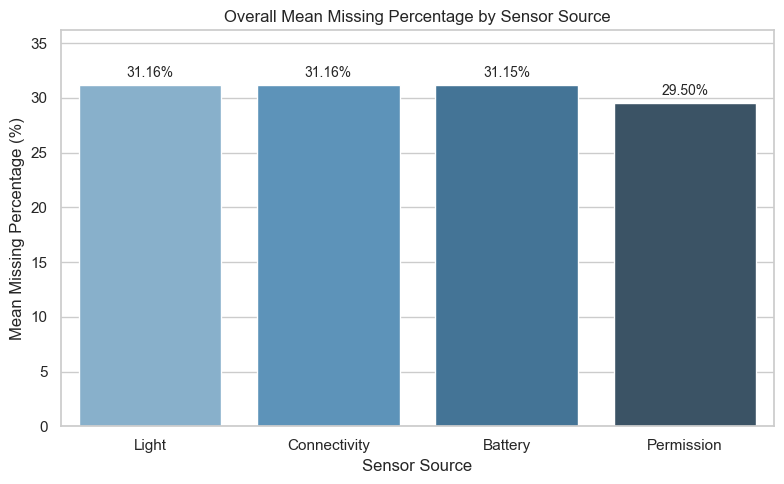

In [133]:
# ÏÑºÏÑú(Source)Î≥Ñ Ï†ÑÏ≤¥ ÌèâÍ∑† ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞
source_mean = df.groupby('Source')['Final Missing %'].mean().sort_values(ascending=False)

# Ï∂úÎ†•
print("üìä ÏÑºÏÑúÎ≥Ñ Ï†ÑÏ≤¥ ÌèâÍ∑† ÎàÑÎùΩÎ•†:")
print(source_mean)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.barplot(x=source_mean.index, y=source_mean.values, palette='Blues_d')
# ÏàòÏπò(label) ÌëúÏãú
for i, value in enumerate(source_mean.values):
    plt.text(i, value + 0.5, f"{value:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title('Overall Mean Missing Percentage by Sensor Source')
plt.ylabel('Mean Missing Percentage (%)')
plt.xlabel('Sensor Source')
plt.ylim(0, max(source_mean.values) + 5)
plt.tight_layout()
plt.show()

### ÏÇ¨Ïö©ÏûêÎ≥Ñ ÎàÑÎùΩÎ•† Î∂ÑÌè¨ Î∂ÑÏÑù

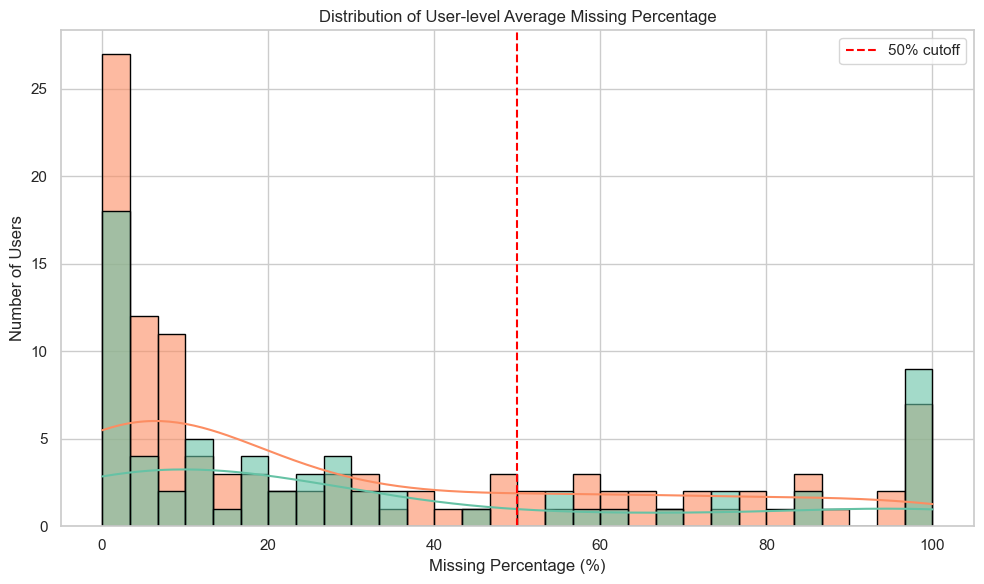

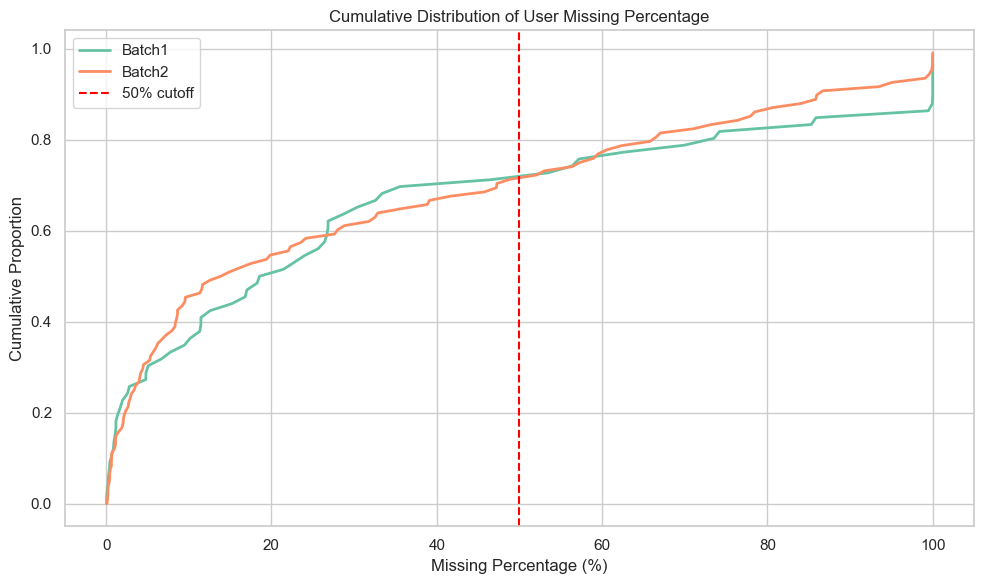


üìã Batch-wise Missing % Descriptive Statistics:
        count   mean    std   min   25%    50%    75%    max
Batch                                                       
Batch1   66.0  32.20  35.08  0.04  2.64  18.41  55.66  100.0
Batch2  108.0  30.52  33.08  0.10  3.30  13.19  56.59  100.0

üìä 50% Cutoff Summary by Batch:
        TotalUsers  NumAbove50  NumBelow50  PctAbove50 (%)  PctBelow50 (%)
Batch                                                                     
Batch1          66          18          48            27.3            72.7
Batch2         108          30          78            27.8            72.2


In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# üîπ Permission ÏÜåÏä§ Ï†úÏô∏
df = df[df['Source'] != 'Permission']

# ÏÇ¨Ïö©ÏûêÎãπ ÌèâÍ∑† ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞
user_missing = df.groupby(['Batch', 'User'])['Final Missing %'].mean().reset_index()

# ‚îÄ‚îÄ‚îÄ(ÏãúÍ∞ÅÌôî ÏΩîÎìú ÏÉùÎûµ)‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# ‚ñ∂ ÌûàÏä§ÌÜ†Í∑∏Îû®+KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=user_missing, x='Final Missing %', hue='Batch', kde=True,
             bins=30, palette='Set2', edgecolor='black', alpha=0.6)
plt.axvline(50, color='red', linestyle='--', label='50% cutoff')
plt.title('Distribution of User-level Average Missing Percentage')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()
palette = sns.color_palette("Set2", n_colors=user_missing['Batch'].nunique())

# ‚ñ∂ ÎàÑÏ†ÅÎ∂ÑÌè¨
plt.figure(figsize=(10, 6))
for (batch, color) in zip(sorted(user_missing['Batch'].unique()), palette):
    subset = user_missing[user_missing['Batch'] == batch]['Final Missing %']
    x = np.sort(subset)
    y = np.arange(len(x)) / float(len(x))
    plt.plot(x, y, label=batch, color=color, linewidth=2)
plt.axvline(50, color='red', linestyle='--', label='50% cutoff')
plt.title('Cumulative Distribution of User Missing Percentage')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ Î°úÍ∑∏Î°ú ÌÜµÍ≥ÑÌëú Ï∂úÎ†• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

# 1) Î∞∞ÏπòÎ≥Ñ ÏöîÏïΩ ÌÜµÍ≥Ñ
stats = user_missing.groupby('Batch')['Final Missing %'].describe().round(2)
print("\nüìã Batch-wise Missing % Descriptive Statistics:")
print(stats)

# 2) 50% Ïª∑Ïò§ÌîÑ Í∏∞Ï§Ä ÏúÑ/ÏïÑÎûò ÏÇ¨Ïö©Ïûê Ïàò¬∑ÎπÑÏú®
total = user_missing.groupby('Batch').size().rename('TotalUsers')
above50 = user_missing[user_missing['Final Missing %'] >= 50].groupby('Batch').size().rename('NumAbove50')
below50 = user_missing[user_missing['Final Missing %'] < 50].groupby('Batch').size().rename('NumBelow50')

summary = pd.concat([total, above50, below50], axis=1).fillna(0).astype(int)
summary['PctAbove50 (%)'] = (summary['NumAbove50'] / summary['TotalUsers'] * 100).round(1)
summary['PctBelow50 (%)'] = (summary['NumBelow50'] / summary['TotalUsers'] * 100).round(1)

print("\nüìä 50% Cutoff Summary by Batch:")
print(summary.to_string())

In [136]:
# user_missing ÏùÄ ÏïûÏÑú Í≥ÑÏÇ∞Ìïú DataFrame:
#   Batch | User       | Final Missing %
#  -------+------------+----------------
#   Batch1| cmp1_usr541|  5.23
#   Batch1| cmp1_usr542| 82.15
#   ...

import pandas as pd

# 1) Î∞∞ÏπòÎ≥ÑÎ°ú ÌèâÍ∑† ÎàÑÎùΩÎ•† Ï†ïÎ†¨ Ï∂úÎ†•
for batch in ['Batch1', 'Batch2']:
    sub = user_missing[user_missing['Batch'] == batch] \
              .sort_values('Final Missing %', ascending=False) \
              .reset_index(drop=True)
    print(f"\n‚îÄ‚îÄ {batch} ‚îÄ‚îÄ")
    print(sub[['User', 'Final Missing %']].to_string(index=False))

# 2) 50% Ïª∑Ïò§ÌîÑ Ï¥àÍ≥º Ïú†Ï†Ä ID Î¶¨Ïä§Ìä∏
above = user_missing[user_missing['Final Missing %'] >= 50]
print("\n‚îÄ‚îÄ High-Missing Users (>=50%) ‚îÄ‚îÄ")
for batch in ['Batch1', 'Batch2']:
    ids = above[above['Batch'] == batch]['User'].tolist()
    print(f"{batch} ({len(ids)}Î™Ö): {ids}")


‚îÄ‚îÄ Batch1 ‚îÄ‚îÄ
       User  Final Missing %
cmp1_usr597       100.000000
cmp1_usr618       100.000000
cmp1_usr608       100.000000
cmp1_usr613       100.000000
cmp1_usr584       100.000000
cmp1_usr542       100.000000
cmp1_usr621       100.000000
cmp1_usr617        99.946667
cmp1_usr645        99.470000
cmp1_usr601        85.880000
cmp1_usr652        85.310000
cmp1_usr588        74.210000
cmp1_usr631        73.530000
cmp1_usr639        69.920000
cmp1_usr590        62.673333
cmp1_usr646        57.190000
cmp1_usr596        56.386667
cmp1_usr616        53.480000
cmp1_usr594        46.530000
cmp1_usr545        35.550000
cmp1_usr586        33.380000
cmp1_usr649        32.590000
cmp1_usr603        30.370000
cmp1_usr582        28.700000
cmp1_usr622        26.850000
cmp1_usr643        26.840000
cmp1_usr619        26.700000
cmp1_usr640        26.430000
cmp1_usr571        25.660000
cmp1_usr624        24.013333
cmp1_usr626        22.740000
cmp1_usr559        21.450000
cmp1_usr651        18

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/72485975.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/72485975.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right')


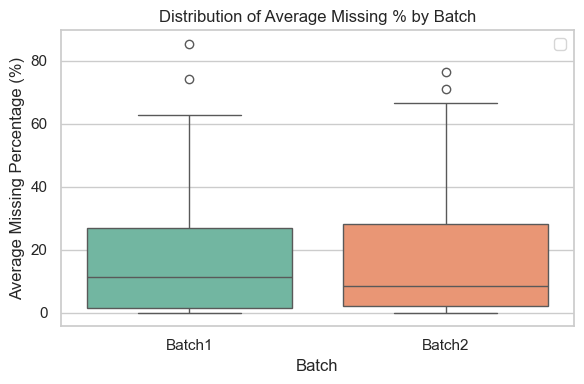

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/72485975.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


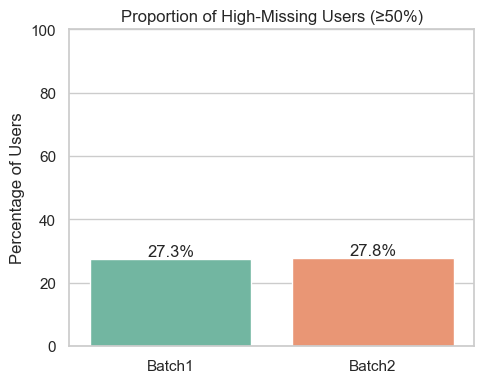

        count   mean    std   min   25%    50%   75%    max
Batch                                                      
Batch1   54.0  18.45  20.59  0.04  1.50  11.46  26.8  85.31
Batch2   88.0  17.79  20.56  0.10  2.32   8.46  28.2  76.39


In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# user_missing: DataFrame with ['Batch','User','Final Missing %']
# summary: ÏúÑÏóêÏÑú ÎßåÎì† 50% Ïª∑Ïò§ÌîÑ ÏöîÏïΩ ÌÖåÏù¥Î∏î (columns=['Batch','TotalUsers','NumAbove50','PctAbove50 (%)'])

sns.set(style="whitegrid")

# ‚îÄ‚îÄ‚îÄ (1) Boxplot: Î∞∞ÏπòÎ≥Ñ ÎàÑÎùΩÎ•† Î∂ÑÌè¨ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
dropout_user_ids_batch1 = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
dropout_user_ids_batch2 = [662, 663, 666, 669, 682, 683, 689, 701, 704, 716, 723, 725, 726, 727, 736, 746, 756, 765, 767, 769]
dropouts = (
    [f"cmp1_usr{uid}" for uid in dropout_user_ids_batch1] +
    [f"cmp1_usr{uid}" for uid in dropout_user_ids_batch2]
)

# dropout ÏÇ¨Ïö©Ïûê Ï†úÍ±∞
filtered_user_missing = user_missing[~user_missing['User'].isin(dropouts)]
plt.figure(figsize=(6,4))
ax1 = sns.boxplot(
    data=filtered_user_missing,
    x='Batch', y='Final Missing %',
    palette=['#66C2A5','#FC8D62']
)
#ax1.axhline(50, color='red', linestyle='--', label='50% cutoff')
ax1.set_title('Distribution of Average Missing % by Batch')
ax1.set_ylabel('Average Missing Percentage (%)')
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ‚îÄ‚îÄ‚îÄ (2) Barplot: 50% Ïª∑Ïò§ÌîÑ Ï¥àÍ≥º ÎπÑÏú® ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(5,4))
ax2 = sns.barplot(
    data=summary,
    x='Batch', y='PctAbove50 (%)',
    palette=['#66C2A5','#FC8D62']
)
for i, v in enumerate(summary['PctAbove50 (%)']):
    ax2.text(i, v + 1, f"{v:.1f}%", ha='center')
ax2.set_ylim(0,100)
ax2.set_title('Proportion of High-Missing Users (‚â•50%)')
ax2.set_ylabel('Percentage of Users')
ax2.set_xlabel('')
plt.tight_layout()
plt.show()
# üîπ Î∞∞ÏπòÎ≥Ñ Í∏∞Ï¥à ÌÜµÍ≥ÑÎüâ Í≥ÑÏÇ∞
summary_stats = (
    filtered_user_missing
    .groupby("Batch")["Final Missing %"]
    .describe()
    .loc[:, ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
    .round(2)
)

# üîπ Ï∂úÎ†•
print(summary_stats)

#### Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê ÎåÄÏÉÅ Weekly dropout rate

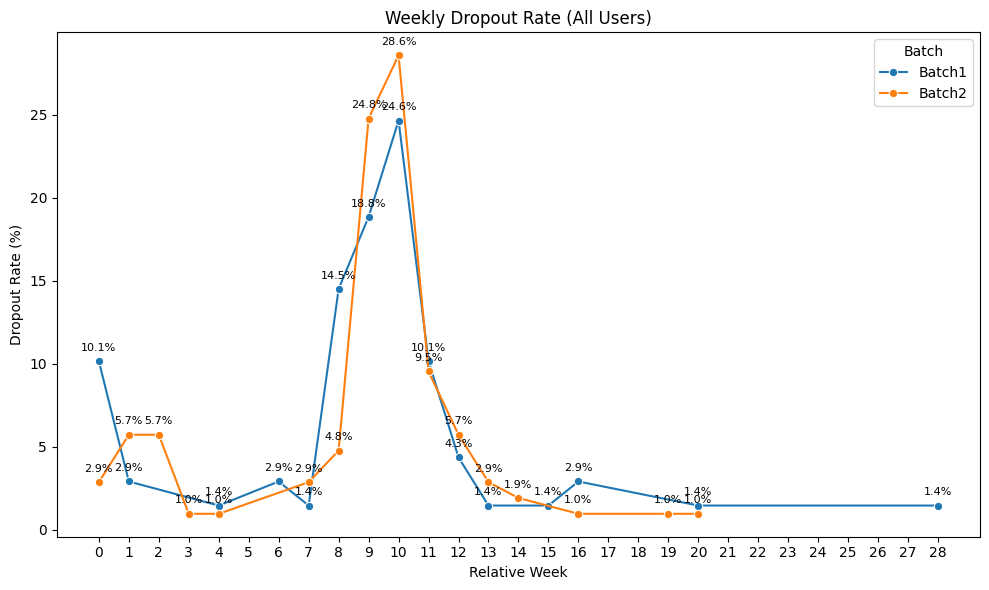

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# üîπ weekly_sample_map: {user_id: {week: sample_count, ...}}
# Ï†ÑÏ†ú: sample countÍ∞Ä 0Ïù∏ Ï≤´ Ï£ºÍ∞Ä dropoutÏúºÎ°ú Í∞ÑÏ£ºÎê®

# üîπ ÏÇ¨Ïö©ÏûêÏùò dropout Ï£ºÏ∞® Í≥ÑÏÇ∞
def get_user_dropout_weeks(weekly_sample_map):
    records = []
    for user_id in weekly_sample_map:
        weeks = weekly_sample_map[user_id]

        if not weeks:  # Îç∞Ïù¥ÌÑ∞Í∞Ä ÏïÑÏòà ÏóÜÏùå ‚Üí 1Ï£ºÏ∞® dropout
            drop_week = 0
        else:
            sorted_weeks = sorted(weeks.items())
            for week, count in sorted_weeks:
                if count == 0:
                    drop_week = week
                    break
            else:
                drop_week = max(weeks.keys()) + 1  # ÎÅùÍπåÏßÄ ÏàòÏßëÌïú Í≤ΩÏö∞

        batch = "Batch1" if int(user_id.split("usr")[-1]) < 660 else "Batch2"
        records.append({
            "User": user_id,
            "DropWeek": drop_week,
            "Batch": batch
        })

    return pd.DataFrame(records)

# üîπ Ï£ºÏ∞®Î≥Ñ Ïù¥ÌÉàÎ•† Í≥ÑÏÇ∞
drop_weeks_all = get_user_dropout_weeks(weekly_sample_map)
drop_counts = drop_weeks_all.groupby(['Batch', 'DropWeek'])['User'].count().reset_index(name='UserCount')

# üîπ ÎπÑÏú® Í≥ÑÏÇ∞
batch_totals = drop_weeks_all.groupby('Batch')['User'].nunique().to_dict()
drop_counts['DropoutRate (%)'] = drop_counts.apply(
    lambda row: (row['UserCount'] / batch_totals[row['Batch']]) * 100, axis=1
)

# üîπ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
sns.lineplot(data=drop_counts, x='DropWeek', y='DropoutRate (%)', hue='Batch', marker='o')

# üîπ Ï£ºÏÑù Ï∂îÍ∞Ä
for i in range(len(drop_counts)):
    row = drop_counts.iloc[i]
    plt.text(row['DropWeek'], row['DropoutRate (%)'] + 0.5, f"{row['DropoutRate (%)']:.1f}%", 
             ha='center', va='bottom', fontsize=8, color='black')

# üîπ Ïä§ÌÉÄÏùº Ï†ïÎ¶¨
plt.title("Weekly Dropout Rate (All Users)")
plt.xlabel("Relative Week")
plt.ylabel("Dropout Rate (%)")
plt.xticks(range(int(drop_weeks_all['DropWeek'].min()), int(drop_weeks_all['DropWeek'].max()) + 1))
plt.legend(title='Batch')
plt.tight_layout()
plt.show()

#### Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê ÎåÄÏÉÅ weekly data submission rate

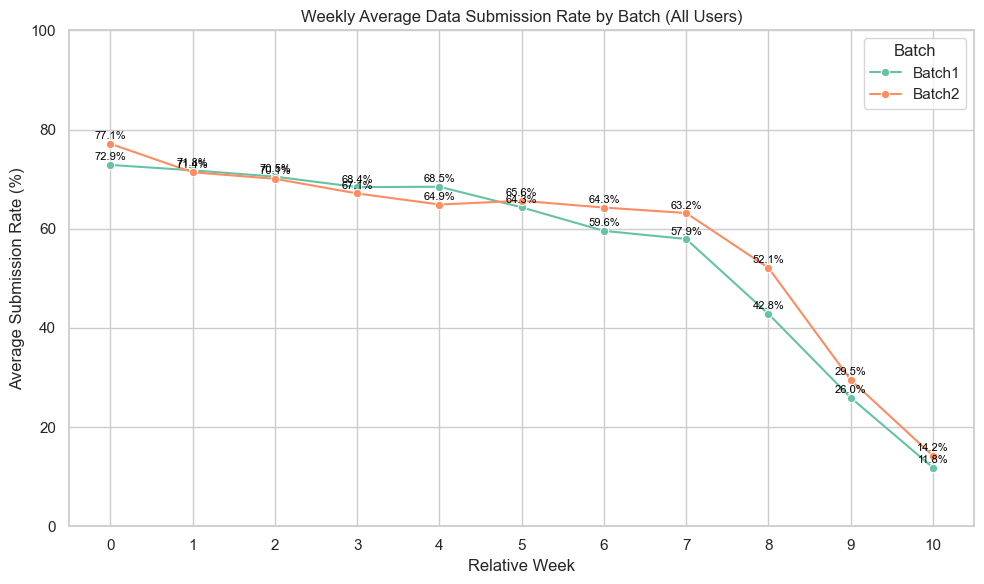

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ Í∏∞Î≥∏ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1", "Batch2"]
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

# Ï£ºÎãπ Í∏∞ÎåÄ ÏÉòÌîå Ïàò (5Î∂ÑÎßàÎã§ 1Ìöå ‚Üí 7*24*60/5)
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016

sns.set(style="whitegrid")

# ‚îÄ‚îÄ‚îÄ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Îßµ ÏÉùÏÑ± Ìï®Ïàò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def build_weekly_sample_map():
    user_week_map = {}
    for batch in BATCHES:
        for user_folder in (BASE_PATH / batch).glob("cmp1_usr*"):
            uid = user_folder.name
            csv_path = user_folder / SENSOR_FOLDER / SENSOR_FILE
            if not csv_path.exists():
                user_week_map[uid] = {}
                continue

            df = pd.read_csv(csv_path, usecols=["timestamp"])
            if df.empty:
                user_week_map[uid] = {}
                continue

            # ÌÉÄÏûÑÏä§ÌÉ¨ÌîÑ ÌååÏã± & Ï§ëÎ≥µÏ†úÍ±∞
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                user_week_map[uid] = {}
                continue

            start = df["ts"].min()
            # ÏÉÅÎåÄÏ£ºÏ∞® Í≥ÑÏÇ∞
            df["week"] = ((df["ts"] - start).dt.days // 7).astype(int)
            # 5Î∂ÑÎ≥¥Îã§ ÏßßÏùÄ Í∞ÑÍ≤© Ï§ëÎ≥µ Ï†úÍ±∞
            def count_valid(xs):
                xs = xs.sort_values()
                last = xs.iloc[0]
                cnt = 1
                for x in xs.iloc[1:]:
                    if (x - last).total_seconds() >= 300:
                        cnt += 1
                        last = x
                return cnt

            weekly_counts = (
                df.groupby("week")["ts"]
                  .apply(count_valid)
                  .to_dict()
            )
            user_week_map[uid] = weekly_counts

    return user_week_map

# ‚îÄ‚îÄ‚îÄ Batch Ï∂îÏ†ï Ìï®Ïàò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def infer_batch(uid):
    # ÏÇ¨Ïö©Ïûê Î≤àÌò∏ 1~659 ‚Üí Batch1, Í∑∏ Ïù¥ÌõÑ ‚Üí Batch2
    num = int(uid.replace("cmp1_usr", ""))
    return "Batch1" if num < 660 else "Batch2"

# ‚îÄ‚îÄ‚îÄ Ï£ºÏ∞®Î≥Ñ ÌèâÍ∑† Ï†úÏ∂úÎ•† Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def compute_weekly_submission_rate(user_week_map):
    # Ï†ÑÏ≤¥ Ï£ºÏ∞® Î¶¨Ïä§Ìä∏
    all_weeks = sorted({w for weeks in user_week_map.values() for w in weeks})

    records = []
    for week in all_weeks:
        for batch in BATCHES:
            # Ìï¥Îãπ Î∞∞ÏπòÏùò Î™®Îì† ÏÇ¨Ïö©Ïûê
            uids = [uid for uid in user_week_map if infer_batch(uid) == batch]
            rates = []
            for uid in uids:
                cnt = user_week_map[uid].get(week, 0)
                rates.append(cnt / EXPECTED_SAMPLES_PER_WEEK)
            avg_rate = np.mean(rates) if rates else 0.0
            records.append({
                "Week": week,
                "Batch": batch,
                "AvgSubmissionRate": avg_rate * 100
            })

    return pd.DataFrame(records)

# ‚îÄ‚îÄ‚îÄ Î©îÏù∏ Ïã§Ìñâ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if __name__ == "__main__":
    user_week_map = build_weekly_sample_map()
    df_sub = compute_weekly_submission_rate(user_week_map)
    df_sub = df_sub[df_sub["Week"] <= 10]
    # ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_sub,
        x="Week", y="AvgSubmissionRate",
        hue="Batch", marker="o", palette="Set2"
    )
    # ÎùºÎ≤®ÎßÅ
    for _, row in df_sub.iterrows():
        plt.text(
            row["Week"], row["AvgSubmissionRate"] + 0.5,
            f"{row['AvgSubmissionRate']:.1f}%",
            ha="center", va="bottom", fontsize=8, color="black"
        )

    plt.title("Weekly Average Data Submission Rate by Batch (All Users)")
    plt.xlabel("Relative Week")
    plt.ylabel("Average Submission Rate (%)")
    plt.ylim(0, 100)
    plt.xticks(sorted(df_sub["Week"].unique()))
    plt.legend(title="Batch")
    plt.tight_layout()
    plt.show()

Loading Batch1: 66it [00:03, 19.83it/s]
Loading Batch2: 108it [00:05, 18.49it/s]


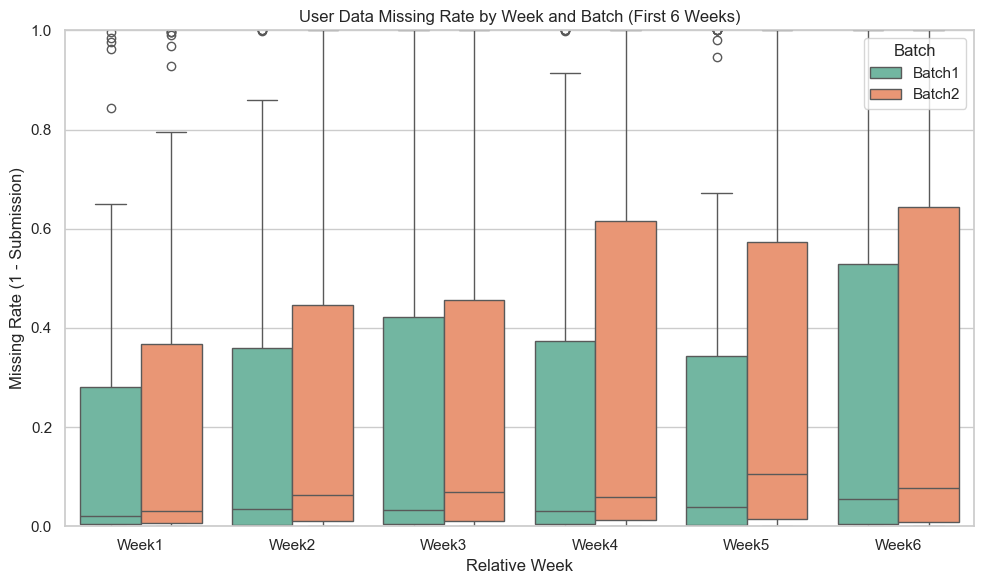

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1", "Batch2"]
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
MAX_WEEKS = 6

sns.set(style="whitegrid")

# ‚îÄ‚îÄ‚îÄ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Îßµ ÏÉùÏÑ± ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def build_weekly_sample_map():
    records = []
    for batch in BATCHES:
        for user_folder in tqdm((BASE_PATH / batch).glob("cmp1_usr*"), desc=f"Loading {batch}"):
            user_id = user_folder.name
            file_path = user_folder / SENSOR_FOLDER / SENSOR_FILE
            if not file_path.exists():
                continue

            df = pd.read_csv(file_path, usecols=["timestamp"])
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                continue

            start = df["ts"].min()
            df["week"] = ((df["ts"] - start).dt.days // 7).astype(int)

            def count_valid(ts_series):
                ts_sorted = ts_series.sort_values()
                last_time = ts_sorted.iloc[0]
                count = 1
                for ts in ts_sorted.iloc[1:]:
                    if (ts - last_time).total_seconds() >= 300:
                        count += 1
                        last_time = ts
                return count

            weekly_counts = (
                df.groupby("week")["ts"]
                .apply(count_valid)
                .to_dict()
            )

            for week in range(MAX_WEEKS):
                count = weekly_counts.get(week, 0)
                missing_rate = 1 - (count / EXPECTED_SAMPLES_PER_WEEK)
                records.append({
                    "User": user_id,
                    "Batch": batch,
                    "Week": f"Week{week+1}",
                    "MissingRate": missing_rate
                })

    return pd.DataFrame(records)

# ‚îÄ‚îÄ‚îÄ Ïã§Ìñâ Î∞è ÏãúÍ∞ÅÌôî ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_box = build_weekly_sample_map()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_box,
    x="Week", y="MissingRate", hue="Batch",
    palette="Set2"
)
plt.ylim(0, 1)
plt.title("User Data Missing Rate by Week and Batch (First 6 Weeks)")
plt.ylabel("Missing Rate (1 - Submission)")
plt.xlabel("Relative Week")
plt.tight_layout()
plt.show()

In [150]:
import pandas as pd
import numpy as np
from scipy import stats

# ‚îÄ‚îÄ‚îÄ (A) df_box Î°úÎìú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# df_box: columns = ['User','Batch','Week','MissingRate'] 
#          Week Í∞íÏùÄ 'Week1'Î∂ÄÌÑ∞ 'Week6'ÍπåÏßÄ ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§.
# Ïòà) df_box = pd.read_csv("boxplot_data.csv")

# ‚îÄ‚îÄ‚îÄ (B) Ï£ºÏ∞®¬∑Î∞∞ÏπòÎ≥Ñ Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
stats_cols = ["count","mean","std","median","min","max"]
summary_stats = (
    df_box
    .groupby(["Week","Batch"])["MissingRate"]
    .agg(stats_cols)
    .round(3)
    .reset_index()
)

# ‚îÄ‚îÄ‚îÄ (C) Ï£ºÏ∞®Î≥Ñ Z-test (Îëê ÎèÖÎ¶ΩÍ∑∏Î£π unequal var t-test) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ztest_results = []
for wk in sorted(df_box["Week"].unique(), key=lambda x: int(x.replace("Week",""))):
    b1 = df_box[(df_box["Week"]==wk) & (df_box["Batch"]=="Batch1")]["MissingRate"]
    b2 = df_box[(df_box["Week"]==wk) & (df_box["Batch"]=="Batch2")]["MissingRate"]
    # Welch‚Äôs t-test ‚âí unequal-var Z-test
    t_stat, p_val = stats.ttest_ind(b1, b2, equal_var=False)
    ztest_results.append({
        "Week": wk,
        "Z (t-stat)": round(t_stat, 3),
        "p-value": round(p_val, 3)
    })
ztest_df = pd.DataFrame(ztest_results)

# ‚îÄ‚îÄ‚îÄ (D) Í≤∞Í≥º ÌôïÏù∏ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print("‚ñ∂ Weekly Descriptive Statistics by Batch:")
print(summary_stats.pivot(index="Week", columns="Batch")[stats_cols])
print("\n‚ñ∂ Weekly Z-test (Batch1 vs Batch2):")
print(ztest_df)

‚ñ∂ Weekly Descriptive Statistics by Batch:
       count          mean           std        median           min         \
Batch Batch1 Batch2 Batch1 Batch2 Batch1 Batch2 Batch1 Batch2 Batch1 Batch2   
Week                                                                          
Week1     59    105  0.192  0.204  0.300  0.292  0.021  0.030    0.0    0.0   
Week2     59    105  0.204  0.262  0.309  0.332  0.035  0.062    0.0    0.0   
Week3     59    105  0.218  0.275  0.316  0.360  0.034  0.068    0.0    0.0   
Week4     59    105  0.233  0.310  0.342  0.383  0.030  0.059    0.0    0.0   
Week5     59    105  0.232  0.333  0.351  0.387  0.039  0.106    0.0    0.0   
Week6     59    105  0.290  0.320  0.365  0.392  0.055  0.077    0.0    0.0   

         max         
Batch Batch1 Batch2  
Week                 
Week1  0.996  0.998  
Week2  1.000  1.000  
Week3  1.000  1.000  
Week4  1.000  1.000  
Week5  1.000  1.000  
Week6  1.000  1.000  

‚ñ∂ Weekly Z-test (Batch1 vs Batch2):
    Wee

In [153]:
!pip install statsmodels

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9.9/9.9 MB 2.6 MB/s eta 0:00:00a 0:00:01m


In [154]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# df_box: columns = ['User','Batch','Week','MissingRate']
# WeekÎ•º Ïà´ÏûêÌòïÏúºÎ°ú Î∞îÍøîÏïº Ìï©ÎãàÎã§:
df_box['WeekNum'] = df_box['Week'].str.replace('Week','').astype(int)

# Mixed ANOVA: Random intercept per User
model = mixedlm(
    "MissingRate ~ C(Batch) * WeekNum",     # fixed effects: Batch, Week, Batch*Week
    df_box,
    groups=df_box["User"]                  # random intercept for each user
)
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    MissingRate
No. Observations:     984        Method:                REML       
No. Groups:           164        Scale:                 0.0365     
Min. group size:      6          Log-Likelihood:        -1.3610    
Max. group size:      6          Converged:             Yes        
Mean group size:      6.0                                          
-------------------------------------------------------------------
                           Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.169    0.045 3.794 0.000  0.082  0.257
C(Batch)[T.Batch2]         0.032    0.056 0.574 0.566 -0.077  0.141
WeekNum                    0.017    0.006 2.828 0.005  0.005  0.028
C(Batch)[T.Batch2]:WeekNum 0.007    0.007 0.927 0.354 -0.008  0.021
Group Var                  0.086    0.058                      

#### Normal users ÎåÄÏÉÅ Weekly data submission rate

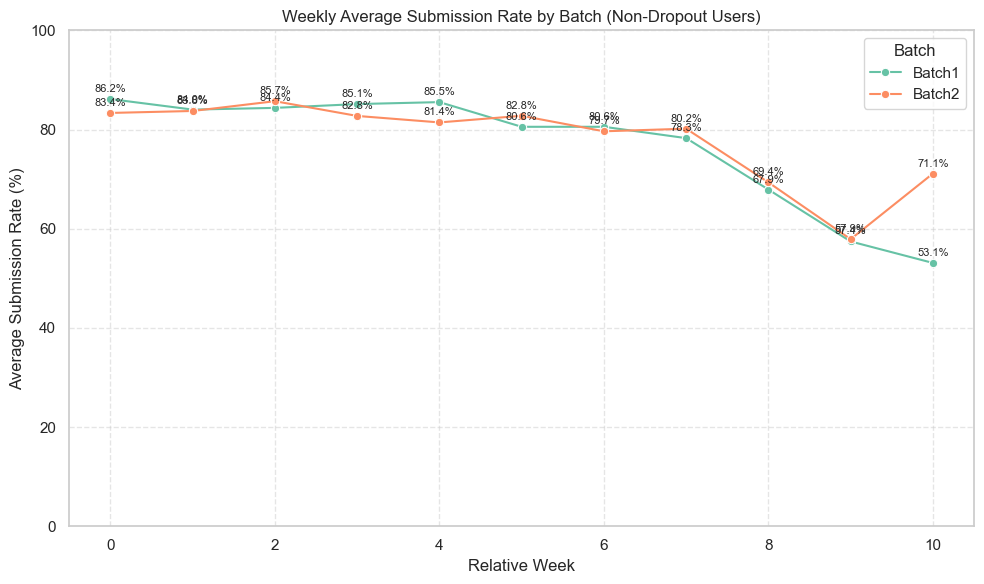

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016
sns.set(style="whitegrid")

# Dropout ÏÇ¨Ïö©Ïûê ID Î¶¨Ïä§Ìä∏
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662, 663, 666, 669, 682, 683, 689, 701, 704, 716, 723, 725, 726, 727, 736, 746, 756, 765, 767, 769]
dropout_users = {f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids}

# ‚îÄ‚îÄ‚îÄ ÎπÑ-ÎìúÎ°≠ÏïÑÏõÉ ÏÇ¨Ïö©Ïûê Ï†ÑÏö© Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Î∞è Ï†úÏ∂úÎ•† Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def build_non_dropout_weekly_records():
    recs = []
    for batch in ["Batch1","Batch2"]:
        for user_folder in (BASE_PATH / batch).glob("cmp1_usr*"):
            uid = user_folder.name
            if uid in dropout_users:
                continue  # ÎìúÎ°≠ÏïÑÏõÉ Ïú†Ï†ÄÎäî Í±¥ÎÑàÎúÄ

            csv_path = user_folder / SENSOR_FOLDER / SENSOR_FILE
            if not csv_path.exists():
                continue

            df = pd.read_csv(csv_path, usecols=["timestamp"])
            if df.empty:
                continue

            # ÌÉÄÏûÑÏä§ÌÉ¨ÌîÑ ÌååÏã± + Ï§ëÎ≥µ Ï†úÍ±∞
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                continue

            # ÏÉÅÎåÄ Ï£ºÏ∞® Í≥ÑÏÇ∞
            start = df["ts"].min()
            df["week"] = ((df["ts"] - start).dt.days // 7).astype(int)

            # 5Î∂Ñ Ïù¥ÎÇ¥ Ï§ëÎ≥µ Ï†úÍ±∞ Ìï®Ïàò
            def count_valid(xs):
                xs = xs.sort_values().reset_index(drop=True)
                last, cnt = xs.iloc[0], 1
                for x in xs.iloc[1:]:
                    if (x - last).total_seconds() >= 300:
                        cnt += 1
                        last = x
                return cnt

            weekly_counts = df.groupby("week")["ts"].apply(count_valid).to_dict()
            for wk, cnt in weekly_counts.items():
                recs.append({
                    "Batch": batch,
                    "Week": wk,
                    "SubmissionRate": cnt / EXPECTED_SAMPLES_PER_WEEK * 100
                })
    return pd.DataFrame(recs)

# ‚îÄ‚îÄ‚îÄ Ïã§Ìñâ Î∞è Í∑∏Î£π ÌèâÍ∑† Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_non = build_non_dropout_weekly_records()
avg_non = df_non.groupby(["Batch","Week"])["SubmissionRate"].mean().reset_index()
avg_non = avg_non[avg_non["Week"] <= 10]

# ‚îÄ‚îÄ‚îÄ Í∫æÏùÄÏÑ† Í∑∏ÎûòÌîÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(10,6))
sns.lineplot(data=avg_non, x="Week", y="SubmissionRate", hue="Batch", marker="o", palette="Set2")

# Í∞í Î†àÏù¥Î∏î Ï∂îÍ∞Ä
for _, row in avg_non.iterrows():
    plt.text(row["Week"], row["SubmissionRate"]+1, f"{row['SubmissionRate']:.1f}%",
             ha="center", va="bottom", fontsize=8)

plt.title("Weekly Average Submission Rate by Batch (Non-Dropout Users)")
plt.xlabel("Relative Week")
plt.ylabel("Average Submission Rate (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

In [5]:
# ÏÇ¨Ïö©ÏûêÎ≥Ñ ÌèâÍ∑† ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞
user_missing = df.groupby(['Batch', 'User'])['Final Missing %'].mean().reset_index()

# ‚úÖ Í≥†ÎàÑÎùΩ Ïó¨Î∂Ä Ïª¨Îüº Î™ÖÏãúÏ†ÅÏúºÎ°ú Ï∂îÍ∞Ä
user_missing['HighMissing'] = user_missing['Final Missing %'] >= 50
user_missing['UserID_NumOnly'] = user_missing['User'].astype(str).str.extract(r'(\d+)$')

# üîπ ÌÜµÍ≥Ñ ÏöîÏïΩ: Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê Ïàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
high_missing_stats = (
    user_missing.groupby('Batch')['HighMissing']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'Num_Users_50plus', 'count': 'Total_Users'})
)
high_missing_stats['Proportion (%)'] = (high_missing_stats['Num_Users_50plus'] / high_missing_stats['Total_Users']) * 100

# üîπ Í≤∞Í≥º Ï∂úÎ†•
print("‚úÖ Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê ÎπÑÏú® (ÎàÑÎùΩÎ•† ‚â• 50% Í∏∞Ï§Ä):")
print(high_missing_stats)

# üîπ BatchÎ≥Ñ Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê ID Ï∂úÎ†•
print("\n‚úÖ Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê Î™©Î°ù (ÎàÑÎùΩÎ•† ‚â• 50%):")
for batch in user_missing['Batch'].unique():
    user_cmp_ids = user_missing[(user_missing['Batch'] == batch) & (user_missing['HighMissing'])]['User'].tolist()
    print(f"üî∏ {batch} ({len(user_cmp_ids)}Î™Ö): {', '.join(user_cmp_ids)}")

for batch in user_missing['Batch'].unique():
    user_ids = user_missing[
        (user_missing['Batch'] == batch) & (user_missing['HighMissing'])
    ]['UserID_NumOnly'].dropna().tolist()
    print(user_ids)
    print(f"üî∏ {batch} ({len(user_ids)}Î™Ö): {', '.join(user_ids)}")

‚úÖ Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê ÎπÑÏú® (ÎàÑÎùΩÎ•† ‚â• 50% Í∏∞Ï§Ä):
        Num_Users_50plus  Total_Users  Proportion (%)
Batch                                                
Batch1                18           66       27.272727
Batch2                31          109       28.440367

‚úÖ Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê Î™©Î°ù (ÎàÑÎùΩÎ•† ‚â• 50%):
üî∏ Batch1 (18Î™Ö): cmp1_usr542, cmp1_usr584, cmp1_usr588, cmp1_usr590, cmp1_usr596, cmp1_usr597, cmp1_usr601, cmp1_usr608, cmp1_usr613, cmp1_usr616, cmp1_usr617, cmp1_usr618, cmp1_usr621, cmp1_usr631, cmp1_usr639, cmp1_usr645, cmp1_usr646, cmp1_usr652
üî∏ Batch2 (31Î™Ö): cmp1_usr660, cmp1_usr662, cmp1_usr663, cmp1_usr666, cmp1_usr669, cmp1_usr678, cmp1_usr682, cmp1_usr683, cmp1_usr685, cmp1_usr686, cmp1_usr689, cmp1_usr690, cmp1_usr701, cmp1_usr704, cmp1_usr705, cmp1_usr712, cmp1_usr716, cmp1_usr717, cmp1_usr723, cmp1_usr725, cmp1_usr726, cmp1_usr727, cmp1_usr731, cmp1_usr736, cmp1_usr746, cmp1_usr750, cmp1_usr756, cmp1_usr764, cmp1_usr765, cmp1_usr767, cmp1_us

### Dropout Analysis

In [17]:
# üîπ Í≥†ÎàÑÎùΩ ÏÇ¨Ïö©Ïûê Ïà´Ïûê ID Î¶¨Ïä§Ìä∏

batch1_nums = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

# üîπ ÏÇ¨Ïö©Ïûê ID Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
batch1_ids = [f"cmp1_usr{uid}" for uid in batch1_nums]
batch2_ids = [f"cmp1_usr{uid}" for uid in batch2_nums]

# üîπ DataFrameÏóêÏÑú ÏÇ¨Ïö©ÏûêÎ≥Ñ ÌïÑÌÑ∞ÎßÅ
df_batch1 = df[df['User'].isin(batch1_ids)].copy()
df_batch2 = df[df['User'].isin(batch2_ids)].copy()

start_map1 = df_batch1.groupby('User')['StartDate'].min().apply(pd.to_datetime).to_dict()
start_map2 = df_batch2.groupby('User')['StartDate'].min().apply(pd.to_datetime).to_dict()

# üîπ ÏÇ¨Ïö©ÏûêÎ≥Ñ EndDate Í∏∞Ï§Ä ÏÉÅÎåÄ Ï£ºÏ∞® Í≥ÑÏÇ∞
df_batch1['DropWeek'] = df_batch1.apply(
    lambda row: (pd.to_datetime(row['EndDate']) - start_map1[row['User']]).days // 7
    if pd.notnull(row['EndDate']) else None,
    axis=1
)
df_batch2['DropWeek'] = df_batch2.apply(
    lambda row: (pd.to_datetime(row['EndDate']) - start_map2[row['User']]).days // 7
    if pd.notnull(row['EndDate']) else None,
    axis=1
)

# üîπ ÏÇ¨Ïö©ÏûêÎ≥Ñ ÎßàÏßÄÎßâ Ï£ºÏ∞®Îßå Ï∂îÏ∂ú
drop_weeks_1 = df_batch1.groupby('User')['DropWeek'].max().reset_index()
drop_weeks_1['Batch'] = 'Batch1'

drop_weeks_2 = df_batch2.groupby('User')['DropWeek'].max().reset_index()
drop_weeks_2['Batch'] = 'Batch2'

# üîπ Î≥ëÌï©
drop_weeks_all = pd.concat([drop_weeks_1, drop_weeks_2], ignore_index=True)

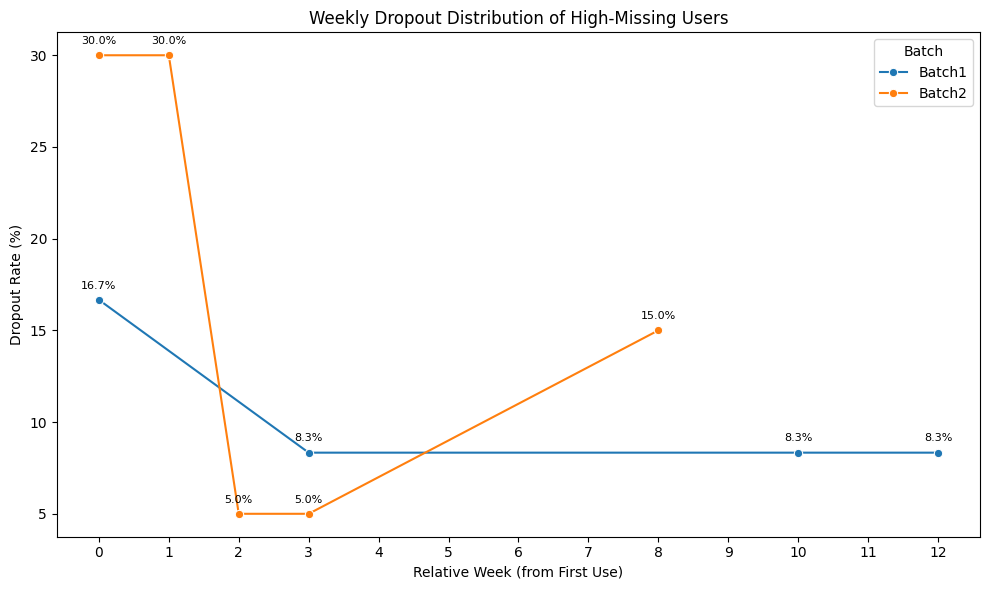

In [18]:
drop_counts = drop_weeks_all.groupby(['Batch', 'DropWeek'])['User'].count().reset_index(name='UserCount')

# üîπ Calculate proportion within each batch
batch_totals = drop_weeks_all.groupby('Batch')['User'].nunique().to_dict()
drop_counts['Proportion (%)'] = drop_counts.apply(
    lambda row: (row['UserCount'] / batch_totals[row['Batch']]) * 100, axis=1
)

# üîπ Visualization: line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=drop_counts, x='DropWeek', y='Proportion (%)', hue='Batch', marker='o')

# üîπ Annotate each point with percentage
for i in range(len(drop_counts)):
    row = drop_counts.iloc[i]
    plt.text(row['DropWeek'], row['Proportion (%)'] + 0.5, f"{row['Proportion (%)']:.1f}%", 
             ha='center', va='bottom', fontsize=8, color='black')

# üîπ English labels and layout
plt.title("Weekly Dropout Distribution of High-Missing Users")
plt.xlabel("Relative Week (from First Use)")
plt.ylabel("Dropout Rate (%)")
plt.xticks(range(int(drop_weeks_all['DropWeek'].min()), int(drop_weeks_all['DropWeek'].max()) + 1))
plt.legend(title='Batch')
plt.tight_layout()
plt.show()

‚ñ∂ Dropout Users' Weeks with Data (by Batch):
        count  mean   std  min  median  max
Batch                                      
Batch1     12  1.42  2.23    0     0.0    6
Batch2     20  1.90  1.45    0     2.0    5


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4124144126.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4124144126.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


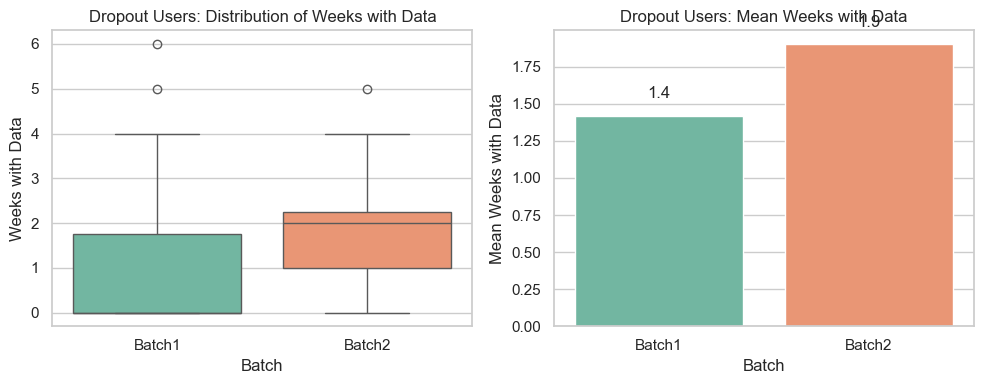

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ (0) Dropout ÏÇ¨Ïö©Ïûê ID Ï†ïÏùò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
batch1_nums = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{u}" for u in batch1_nums + batch2_nums}

# ‚îÄ‚îÄ‚îÄ (1) ÏïûÏÑú ÎßåÎì† user_week_map Ïû¨ÏÇ¨Ïö© ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# user_week_map = build_weekly_sample_map()  # Ïù¥ÎØ∏ ÎßåÎì§Ïñ¥ÏßÑ dictÏù¥ÎùºÍ≥† Í∞ÄÏ†ï

# ‚îÄ‚îÄ‚îÄ (2) Dropout ÏÇ¨Ïö©ÏûêÎßå ÌïÑÌÑ∞ÎßÅÌï¥ÏÑú Ï£ºÏ∞® Í∞úÏàò Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
records = []
for uid, weeks in user_week_map.items():
    if uid not in dropout_ids:
        continue
    batch = "Batch1" if int(uid.replace("cmp1_usr","")) < 660 else "Batch2"
    # Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Ï£ºÏ∞® Ïàò
    num_weeks = len([w for w,c in weeks.items() if c > 0])
    records.append({"User": uid, "Batch": batch, "WeeksWithData": num_weeks})

df_dropout_weeks = pd.DataFrame(records)

# ‚îÄ‚îÄ‚îÄ (3) Î∞∞ÏπòÎ≥Ñ ÌèâÍ∑†¬∑ÌëúÏ§ÄÌé∏Ï∞® Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
stats = (
    df_dropout_weeks
    .groupby("Batch")["WeeksWithData"]
    .agg(["count","mean","std","min","median","max"])
    .round(2)
)
print("‚ñ∂ Dropout Users' Weeks with Data (by Batch):")
print(stats)

# ‚îÄ‚îÄ‚îÄ (4) ÏãúÍ∞ÅÌôî: Î∞ïÏä§ÌîåÎ°Ø / Î∞îÌîåÎ°Ø ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
sns.set(style="whitegrid")
fig, axes = plt.subplots(1,2,figsize=(10,4))

# 4-1) Î∞ïÏä§ÌîåÎ°Ø
sns.boxplot(
    data=df_dropout_weeks,
    x="Batch", y="WeeksWithData",
    palette=["#66C2A5","#FC8D62"],
    ax=axes[0]
)
axes[0].set_title("Dropout Users: Distribution of Weeks with Data")
axes[0].set_ylabel("Weeks with Data")

# 4-2) Î∞îÌîåÎ°Ø (ÌèâÍ∑†)
mean_vals = df_dropout_weeks.groupby("Batch")["WeeksWithData"].mean().reset_index()
sns.barplot(
    data=mean_vals,
    x="Batch", y="WeeksWithData",
    palette=["#66C2A5","#FC8D62"],
    ax=axes[1]
)
for i,row in mean_vals.iterrows():
    axes[1].text(i, row["WeeksWithData"]+0.1, f"{row['WeeksWithData']:.1f}", 
                 ha="center", va="bottom")
axes[1].set_title("Dropout Users: Mean Weeks with Data")
axes[1].set_ylabel("Mean Weeks with Data")

plt.tight_layout()
plt.show()

#### Dropout users Ï§ë Early/Late Íµ¨Î∂Ñ

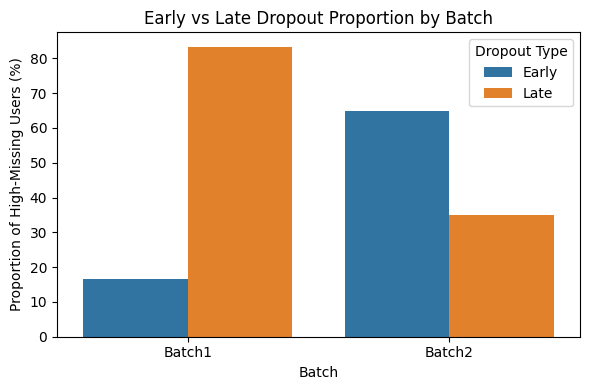

Batch  Count_Early  Count_Late  Proportion_Early (%)  Proportion_Late (%)
0  Batch1          2.0        10.0                  16.7                 83.3
1  Batch2         13.0         7.0                  65.0                 35.0

In [19]:
# Ïù¥ÌÉà Ïú†Ìòï Î∂ÑÎ•ò
drop_weeks_all['DropoutType'] = drop_weeks_all['DropWeek'].apply(
    lambda x: 'Early' if x <= 2 else 'Late'
)

# BatchÎ≥Ñ Ïù¥ÌÉà Ïú†Ìòï ÎπÑÏú® Í≥ÑÏÇ∞
dropout_type_counts = (
    drop_weeks_all.groupby(['Batch', 'DropoutType'])['User']
    .count()
    .reset_index(name='Count')
)

# ÎπÑÏú® Ï∂îÍ∞Ä
total_per_batch = dropout_type_counts.groupby('Batch')['Count'].transform('sum')
dropout_type_counts['Proportion (%)'] = (dropout_type_counts['Count'] / total_per_batch) * 100

# ÏãúÍ∞ÅÌôî (ÎßâÎåÄÍ∑∏ÎûòÌîÑ)
plt.figure(figsize=(6, 4))
sns.barplot(data=dropout_type_counts, x='Batch', y='Proportion (%)', hue='DropoutType')
plt.title("Early vs Late Dropout Proportion by Batch")
plt.ylabel("Proportion of High-Missing Users (%)")
plt.xlabel("Batch")
plt.legend(title="Dropout Type")
plt.tight_layout()
plt.show()

# üîπ Ï†ÑÏ≤¥ ÎåÄÎπÑ ÎπÑÏú® Í≥ÑÏÇ∞
dropout_type_counts['Total'] = dropout_type_counts.groupby('Batch')['Count'].transform('sum')
dropout_type_counts['Proportion (%)'] = (dropout_type_counts['Count'] / dropout_type_counts['Total']) * 100

# üîπ Ìëú ÌòïÌÉú Ï∂úÎ†•
dropout_table = dropout_type_counts.pivot(index='Batch', columns='DropoutType', values=['Count', 'Proportion (%)'])
dropout_table = dropout_table.round(1)  # ÏÜåÏàòÏ†ê Î∞òÏò¨Î¶º

# Î≥¥Í∏∞ Ï¢ãÍ≤å Ïª¨Îüº Ï†ïÎ¶¨
dropout_table.columns = ['Count_Early', 'Count_Late', 'Proportion_Early (%)', 'Proportion_Late (%)']
dropout_table = dropout_table.reset_index()

# ‚úÖ Ìëú Ï∂úÎ†•
import IPython.display as disp
disp.display(dropout_table)

##### High missing rate users' data collection per week_Heatmap

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4250794296.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=all_weeks).fillna(0)


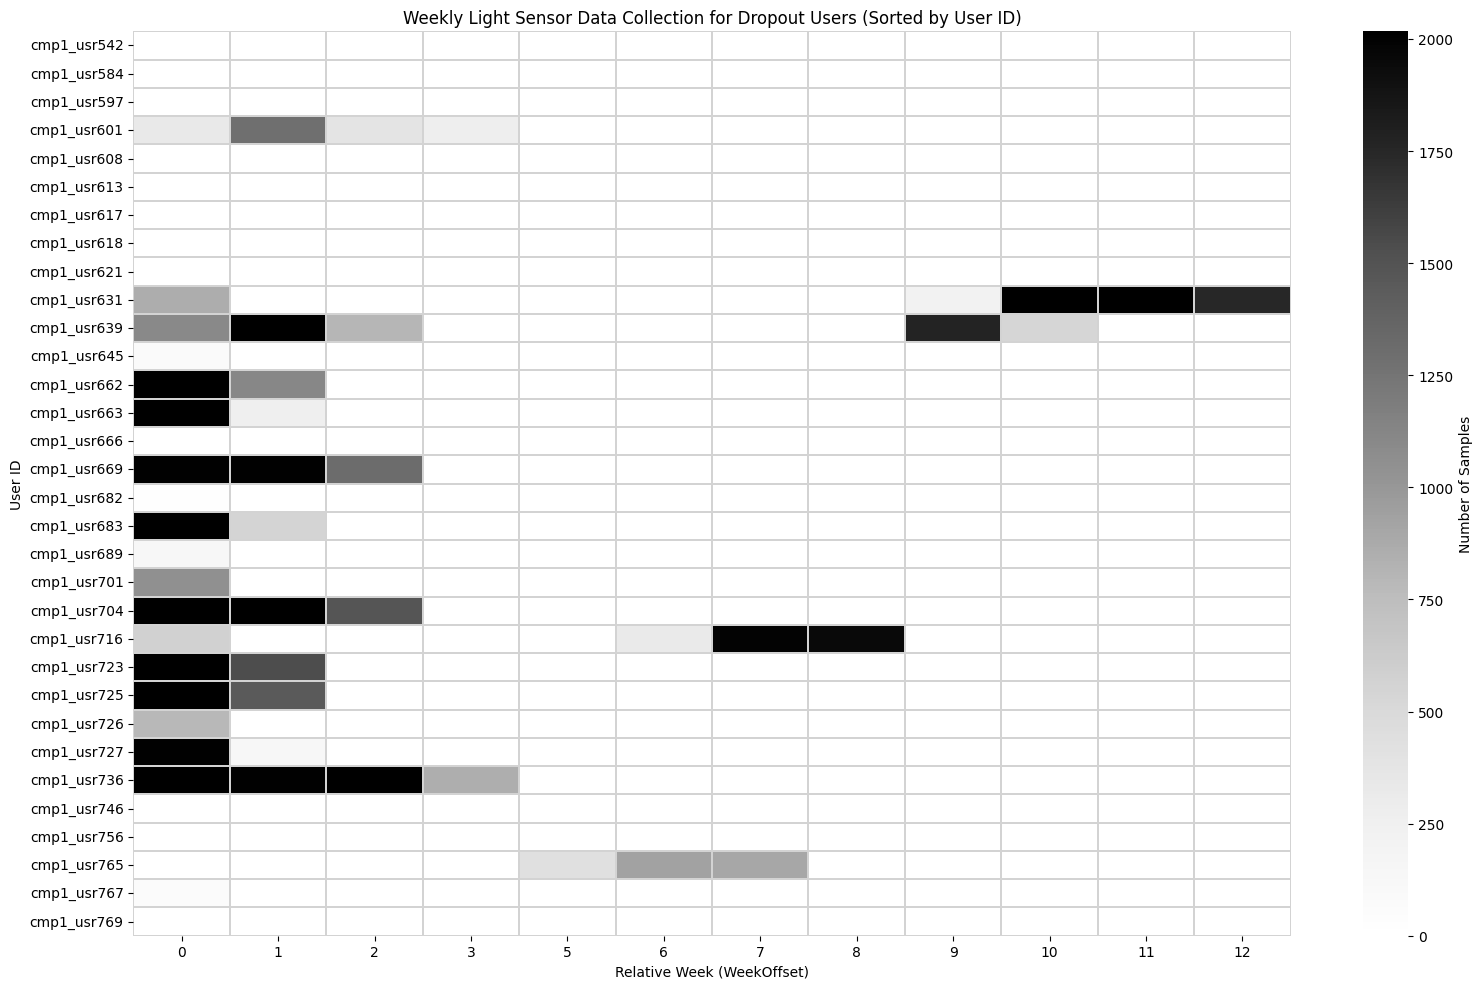

In [20]:
# üîπ Í≥†ÎàÑÎùΩÏûê ID Î¶¨Ïä§Ìä∏ (batchÎ≥Ñ)
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

user_week_data = {}

# üîÅ Í∞Å ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Í≥ÑÏÇ∞
for batch, user_ids in [("Batch1", batch1_ids), ("Batch2", batch2_ids)]:
    for uid in user_ids:
        user_id = f"cmp1_usr{uid}"
        file_path = BASE_PATH / batch / user_id / SENSOR_FOLDER / SENSOR_FILE
        
        if not file_path.exists():
            user_week_data[user_id] = {}  # ÎπÑÏñ¥ ÏûàÎäî ÏÇ¨Ïö©ÏûêÎèÑ Ìè¨Ìï®
            continue
        
        try:
            df = pd.read_csv(file_path)
            if df.empty or 'timestamp' not in df.columns:
                user_week_data[user_id] = {}
                continue
            
            timestamps = pd.to_datetime(df['timestamp'], errors='coerce').dropna()
            if timestamps.empty:
                user_week_data[user_id] = {}
                continue

            # ÏÉÅÎåÄ Ï£ºÏ∞® Í≥ÑÏÇ∞
            start_time = timestamps.min()
            week_offsets = ((timestamps - start_time).dt.days // 7).astype(int)
            week_counts = week_offsets.value_counts().to_dict()
            user_week_data[user_id] = week_counts

        except Exception as e:
            print(f"‚ùå Error processing {user_id}: {e}")
            user_week_data[user_id] = {}

# üîπ Ïú†ÎãàÌÅ¨Ìïú Ï†ÑÏ≤¥ Ï£ºÏ∞® Î≤îÏúÑ
all_weeks = sorted(set(week for counts in user_week_data.values() for week in counts.keys()))

# üîπ ÌûàÌä∏Îßµ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Íµ¨ÏÑ±
heatmap_df = pd.DataFrame(index=sorted(user_week_data.keys(), key=lambda x: int(x.split('usr')[-1])),
                          columns=all_weeks).fillna(0)

for user, week_counts in user_week_data.items():
    for week, count in week_counts.items():
        heatmap_df.loc[user, week] = count

# üîπ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(16, max(10, 0.25 * len(heatmap_df))))
sns.heatmap(
    heatmap_df.astype(float),
    cmap="Greys",
    linewidths=0.3,
    linecolor="lightgray",
    cbar_kws={"label": "Number of Samples"}
)

plt.title("Weekly Light Sensor Data Collection for Dropout Users (Sorted by User ID)")
plt.xlabel("Relative Week (WeekOffset)")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1015922018.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(index=sorted_user_ids(user_map.keys()), columns=all_weeks).fillna(0)
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1015922018.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(index=sorted_user_ids(user_map.keys()), columns=all_weeks).fillna(0)
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1015922018.py:91: UserWarning: Glyph 128202 (\N{BAR CHART}) mis

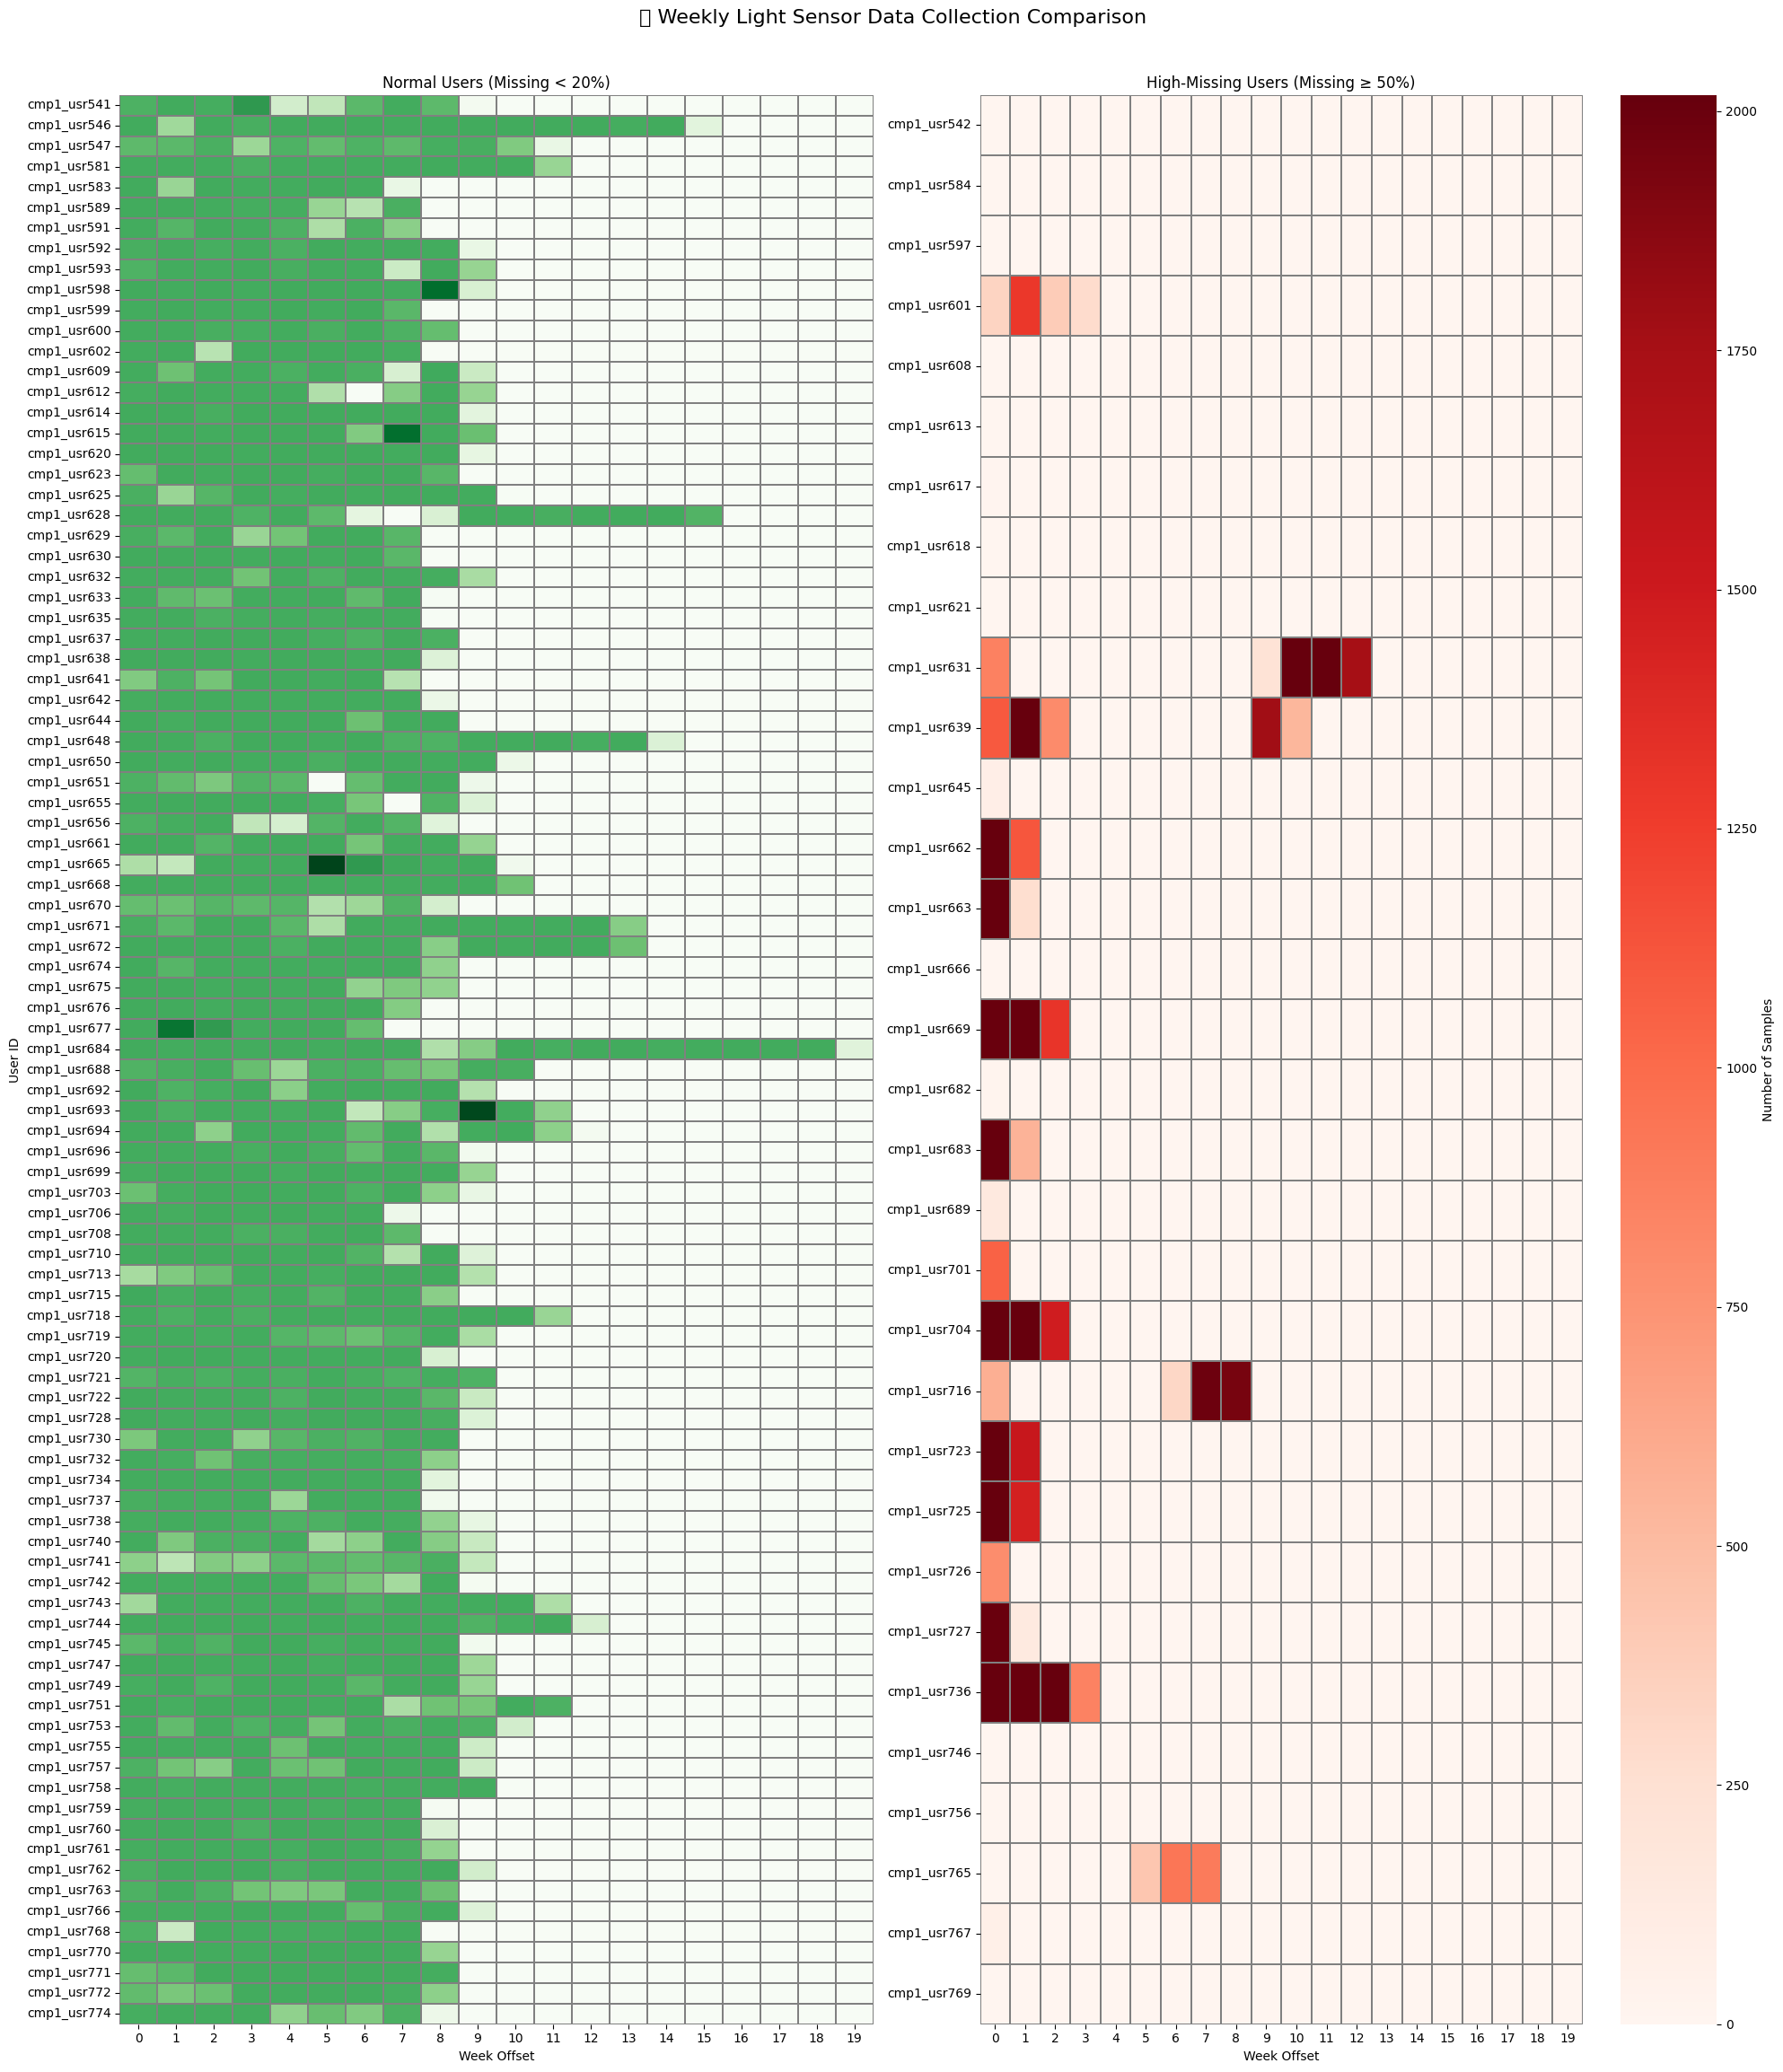

In [21]:
# üîπ ÏÑºÏÑú ÏÑ§Ï†ï
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

# üîπ Í≥†ÎàÑÎùΩÏûê ID (Ïà´Ïûê ÌòïÌÉú)
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]

high_user_ids = [f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids]

# üîπ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Ï†ÑÏ≤òÎ¶¨
df = pd.read_csv("final_corrected_missing_summary.csv")
df['StartDate'] = pd.to_datetime(df['StartDate'])
df = df[df['Source'] != 'Permission']  # Permission Ï†úÏô∏

# üîπ ÌèâÍ∑† ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞ ‚Üí Ï†ïÏÉÅ ÏÇ¨Ïö©Ïûê Ï∂îÏ∂ú (Light Í∏∞Ï§Ä)
user_missing = df[df['Source'] == 'Light'].groupby(['User', 'Batch'])['Final Missing %'].mean().reset_index()
normal_df = user_missing[user_missing['Final Missing %'] < 20]
normal_users = normal_df['User'].tolist()

# üîπ ÏÇ¨Ïö©Ïûê ‚Üí Î∞∞Ïπò Îß§Ìïë ÏÉùÏÑ±
normal_batch_map = dict(zip(normal_df['User'], normal_df['Batch']))
high_batch_map = {f"cmp1_usr{uid}": "Batch1" for uid in batch1_ids}
high_batch_map.update({f"cmp1_usr{uid}": "Batch2" for uid in batch2_ids})

# üîπ Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Í≥ÑÏÇ∞ Ìï®Ïàò
def get_weekly_sample_map(user_batch_map):
    user_map = {}
    for user_id, batch in user_batch_map.items():
        file_path = BASE_PATH / batch / user_id / SENSOR_FOLDER / SENSOR_FILE
        if not file_path.exists():
            user_map[user_id] = {}
            continue
        try:
            df = pd.read_csv(file_path)
            if df.empty or 'timestamp' not in df.columns:
                user_map[user_id] = {}
                continue
            timestamps = pd.to_datetime(df['timestamp'], errors='coerce').dropna()
            if timestamps.empty:
                user_map[user_id] = {}
                continue
            start = timestamps.min()
            week_offset = ((timestamps - start).dt.days // 7).astype(int)
            count_map = week_offset.value_counts().to_dict()
            user_map[user_id] = count_map
        except Exception as e:
            print(f"‚ùå Error: {user_id} ‚Üí {e}")
            user_map[user_id] = {}
    return user_map

# üîπ Ï†ïÎ†¨ Ìï®Ïàò
def sorted_user_ids(user_list):
    return sorted(user_list, key=lambda x: int(x.split('usr')[-1]))

# üîπ ÌûàÌä∏Îßµ DF ÏÉùÏÑ± Ìï®Ïàò
def to_heatmap_df(user_map, all_weeks):
    df = pd.DataFrame(index=sorted_user_ids(user_map.keys()), columns=all_weeks).fillna(0)
    for user, week_counts in user_map.items():
        for week, count in week_counts.items():
            df.loc[user, week] = count
    return df.astype(float)

# üîπ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
normal_map = get_weekly_sample_map(normal_batch_map)
high_map = get_weekly_sample_map(high_batch_map)

# üîπ Ï†ÑÏ≤¥ Ï£ºÏ∞® Î™©Î°ù
all_weeks = sorted(set(week for d in list(normal_map.values()) + list(high_map.values()) for week in d))

# üîπ ÌûàÌä∏ÎßµÏö© DataFrame
heat_normal = to_heatmap_df(normal_map, all_weeks)
heat_high = to_heatmap_df(high_map, all_weeks)

# üîπ ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(20, max(10, 0.25 * max(len(heat_normal), len(heat_high)))), sharey=False)

sns.heatmap(heat_normal, cmap="Greens", ax=axes[0], cbar=False,
            linewidths=0.2, linecolor="gray")
axes[0].set_title("Normal Users (Missing < 20%)")
axes[0].set_xlabel("Week Offset")
axes[0].set_ylabel("User ID")

sns.heatmap(heat_high, cmap="Reds", ax=axes[1], cbar_kws={"label": "Number of Samples"},
            linewidths=0.2, linecolor="gray")
axes[1].set_title("High-Missing Users (Missing ‚â• 50%)")
axes[1].set_xlabel("Week Offset")

plt.suptitle("üìä Weekly Light Sensor Data Collection Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [8]:
!pip install openpyxl

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2435974249.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_df = pd.DataFrame(index=user_ids_sorted, columns=all_weeks).fillna(0)
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2435974249.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '63.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  heatmap_df.loc[user_id, week] = round(ratio * 100, 1)  # ÎπÑÏú®(%)Î°ú Ï†ÄÏû•
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2435974249.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

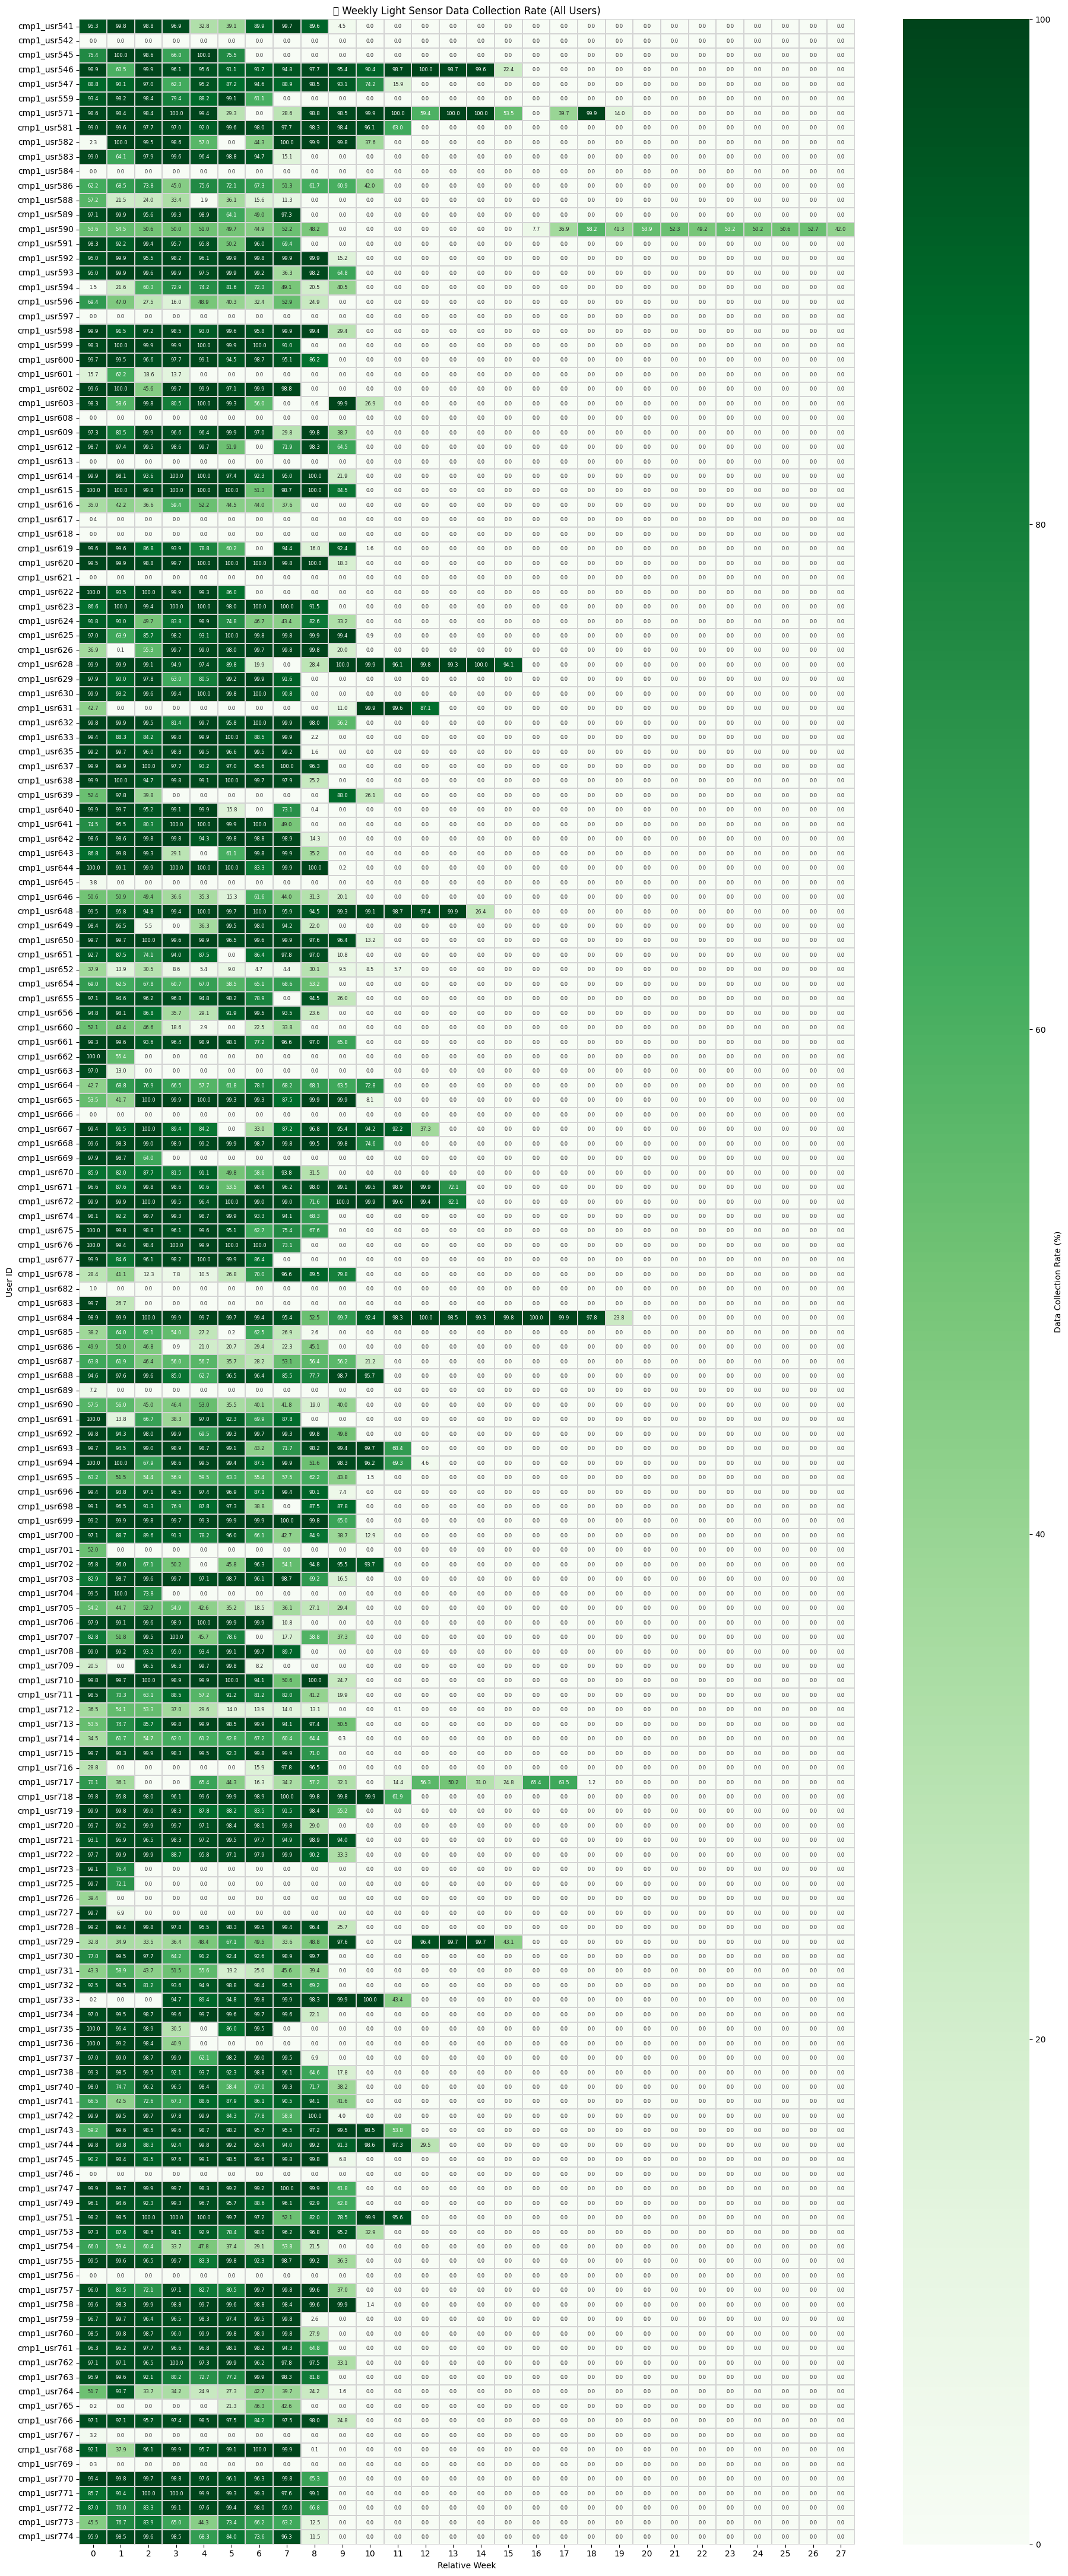

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Í∏∞Î≥∏ ÏÑ§Ï†ï
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
BATCHES = ["Batch1", "Batch2"]
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016
OUTPUT_PATH = Path("./analysis_outputs")
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

MIN_INTERVAL_SECONDS = 300  # 5Î∂Ñ

# üîπ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Í≥ÑÏÇ∞ Ìï®Ïàò
def get_all_users_weekly_sample_count():
    user_week_map = {}
    for batch in BATCHES:
        batch_path = BASE_PATH / batch
        if not batch_path.exists():
            continue

        for user_folder in batch_path.iterdir():
            if not user_folder.is_dir():
                continue

            user_id = user_folder.name
            file_path = user_folder / SENSOR_FOLDER / SENSOR_FILE

            if not file_path.exists():
                user_week_map[user_id] = {}
                continue

            try:
                df = pd.read_csv(file_path)
                if df.empty or 'timestamp' not in df.columns:
                    user_week_map[user_id] = {}
                    continue

                unique_timestamps = pd.to_datetime(df['timestamp'], errors='coerce').dropna().drop_duplicates()
                if unique_timestamps.empty:
                    user_week_map[user_id] = {}
                    continue

                start_time = unique_timestamps.min()
                week_offsets = ((unique_timestamps - start_time).dt.days // 7).astype(int)
                df_valid = pd.DataFrame({'timestamp': unique_timestamps, 'week': week_offsets})

                def count_valid_samples(ts_series):
                    ts_sorted = ts_series.sort_values().reset_index(drop=True)
                    filtered = [ts_sorted.iloc[0]]
                    for ts in ts_sorted.iloc[1:]:
                        if (ts - filtered[-1]).total_seconds() >= 300:
                            filtered.append(ts)
                    return len(filtered)
                
                #counts = week_offsets.value_counts().to_dict()
                #user_week_map[user_id] = counts
                valid_counts = df_valid.groupby('week')['timestamp'].apply(count_valid_samples).to_dict()
                user_week_map[user_id] = valid_counts

            except Exception as e:
                print(f"‚ùå Error reading {file_path}: {e}")
                user_week_map[user_id] = {}

    return user_week_map

# üîπ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
weekly_sample_map = get_all_users_weekly_sample_count()

# üîπ Ï†ÑÏ≤¥ Ï£ºÏ∞® Î™©Î°ùÍ≥º ÏÇ¨Ïö©Ïûê Ï†ïÎ†¨
all_weeks = sorted({week for weeks in weekly_sample_map.values() for week in weeks})
user_ids_sorted = sorted(weekly_sample_map.keys(), key=lambda x: int(x.split('usr')[-1]))

# üîπ ÎπÑÏú® (%) Í≥ÑÏÇ∞Ïö© ÌûàÌä∏Îßµ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
heatmap_df = pd.DataFrame(index=user_ids_sorted, columns=all_weeks).fillna(0)

for user_id, week_counts in weekly_sample_map.items():
    for week, count in week_counts.items():
        ratio = count / EXPECTED_SAMPLES_PER_WEEK
        heatmap_df.loc[user_id, week] = round(ratio * 100, 1)  # ÎπÑÏú®(%)Î°ú Ï†ÄÏû•

# üîπ ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(18, max(10, 0.25 * len(heatmap_df))))
ax = sns.heatmap(
    heatmap_df.astype(float),
    cmap="Greens",
    linewidths=0.3,
    linecolor="lightgray",
    cbar_kws={"label": "Data Collection Rate (%)"},
    annot=heatmap_df.astype(float),
    fmt=".1f",
    annot_kws={"size": 6}
)

plt.title("üìä Weekly Light Sensor Data Collection Rate (All Users)")
plt.xlabel("Relative Week")
plt.ylabel("User ID")
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "heatmap_sensor_collection_rate_with_percent.png")
plt.show()

# üîπ ÏóëÏÖÄÎ°ú Ï†ÄÏû•
#heatmap_df.to_excel(OUTPUT_PATH / "weekly_sensor_collection_rate_percent2.xlsx")

#### Dropout users

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2697977320.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="batch", y="dropout_week", palette="pastel")


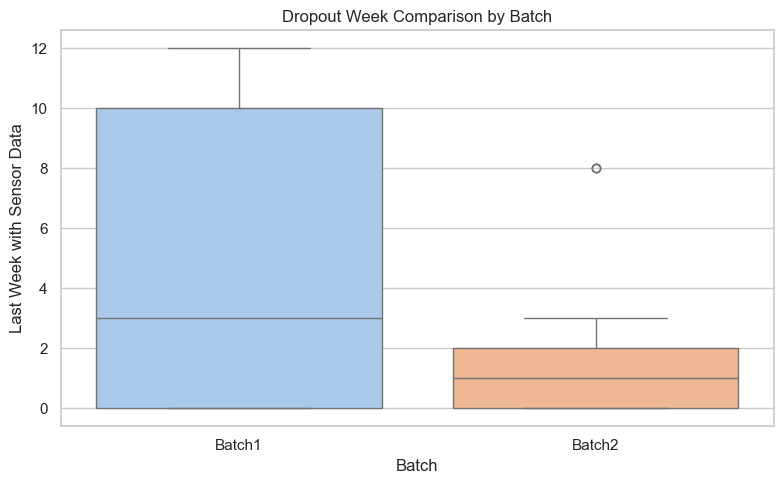

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/2697977320.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="batch", y="dropout_missing_rate", palette="Set2")


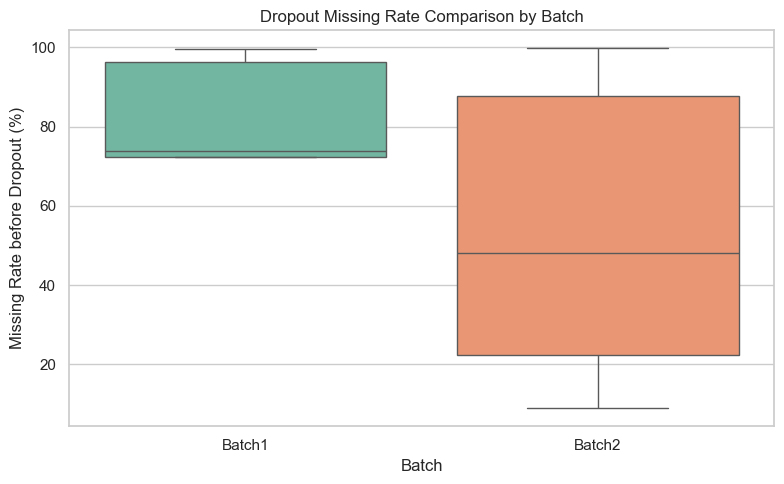

üìã Dropout Summary Table by Batch (Missing Rate):
        dropout_week_count  dropout_week_mean  dropout_week_std  \
batch                                                             
Batch1                   5               5.00              5.66   
Batch2                  17               2.06              2.95   

        dropout_week_min  dropout_week_median  dropout_week_max  \
batch                                                             
Batch1                 0                  3.0                12   
Batch2                 0                  1.0                 8   

        missing_rate_count  missing_rate_mean  missing_rate_std  \
batch                                                             
Batch1                   5              82.88             13.77   
Batch2                  17              54.75             33.18   

        missing_rate_min  missing_rate_median  missing_rate_max  
batch                                                            
Batch1   

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
sns.set(style="whitegrid")
OUTPUT_PATH = Path("./analysis_outputs")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Dropout ÏÇ¨Ïö©Ïûê ID Î¶¨Ïä§Ìä∏ (Î¨∏ÏûêÏó¥)
batch1_ids = [f"cmp1_usr{uid}" for uid in [542,584,597,601,608,613,617,618,621,631,639,645]]
batch2_ids = [f"cmp1_usr{uid}" for uid in [662,663,666,669,682,683,689,701,704,716,723,725,
                                          726,727,736,746,756,765,767,769]]
dropout_users = batch1_ids + batch2_ids

# ‚îÄ‚îÄ‚îÄ Dropout ÌÜµÍ≥Ñ ÏàòÏßë Ìï®Ïàò(ÎàÑÎùΩÎ•† Í≥ÑÏÇ∞) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def get_dropout_stats(user_ids, weekly_map):
    recs = []
    for uid in user_ids:
        if uid not in weekly_map: 
            continue
        wmap = weekly_map[uid]
        if not wmap:
            continue

        last_week = max(wmap.keys())
        total_collected = sum(cnt for wk, cnt in wmap.items() if wk <= last_week)
        expected_total = (last_week + 1) * EXPECTED_SAMPLES_PER_WEEK

        # submission_rate = total_collected / expected_total
        missing_rate = 1 - (total_collected / expected_total) if expected_total>0 else 0

        recs.append({
            "user_id": uid,
            "dropout_week": last_week,
            "dropout_missing_rate": missing_rate * 100  # % Îã®ÏúÑ
        })
    return pd.DataFrame(recs)

# ‚îÄ‚îÄ‚îÄ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df1 = get_dropout_stats(batch1_ids, weekly_sample_map)
df1["batch"] = "Batch1"
df2 = get_dropout_stats(batch2_ids, weekly_sample_map)
df2["batch"] = "Batch2"

df_all = pd.concat([df1, df2], ignore_index=True)

# ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî 1: Ïù¥ÌÉà Ï£ºÏ∞® ÎπÑÍµê ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="batch", y="dropout_week", palette="pastel")
plt.title("Dropout Week Comparison by Batch")
plt.ylabel("Last Week with Sensor Data")
plt.xlabel("Batch")
plt.tight_layout()
plt.savefig(OUTPUT_PATH/"dropout_week_comparison.png")
plt.show()

# ‚îÄ‚îÄ‚îÄ ÏãúÍ∞ÅÌôî 2: Ïù¥ÌÉà Ï†Ñ ÎàÑÎùΩÎ•† ÎπÑÍµê ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="batch", y="dropout_missing_rate", palette="Set2")
plt.title("Dropout Missing Rate Comparison by Batch")
plt.ylabel("Missing Rate before Dropout (%)")
plt.xlabel("Batch")
plt.tight_layout()
plt.savefig(OUTPUT_PATH/"dropout_missing_rate_comparison.png")
plt.show()

# ‚îÄ‚îÄ‚îÄ Î∞∞ÏπòÎ≥Ñ ÏöîÏïΩ ÌÜµÍ≥ÑÌëú ÏÉùÏÑ± ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
summary = (
    df_all
    .groupby("batch")
    .agg(
        dropout_week_count=("dropout_week","count"),
        dropout_week_mean=("dropout_week","mean"),
        dropout_week_std=("dropout_week","std"),
        dropout_week_min=("dropout_week","min"),
        dropout_week_median=("dropout_week","median"),
        dropout_week_max=("dropout_week","max"),
        missing_rate_count=("dropout_missing_rate","count"),
        missing_rate_mean=("dropout_missing_rate","mean"),
        missing_rate_std=("dropout_missing_rate","std"),
        missing_rate_min=("dropout_missing_rate","min"),
        missing_rate_median=("dropout_missing_rate","median"),
        missing_rate_max=("dropout_missing_rate","max")
    )
    .round(2)
)

print("üìã Dropout Summary Table by Batch (Missing Rate):")
print(summary)

# Ï†ÄÏû•
#summary.to_excel(OUTPUT_PATH/"dropout_summary_missing_rate_by_batch.xlsx")

### ÏÉùÏ°¥ Î∂ÑÏÑù (Survival Analysis)

In [38]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22.4/22.4 MB 2.3 MB/s eta 0:00:0000:0100:01
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=f47da8ca683467d7420070c869b0e068f7fc869ab757c566851af33c43fe351a
  Stored in directory: /Users/yooseohyeon/Library/Caches/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


‚úÖ weekly_sample_map.pkl Ï†ÄÏû• ÏôÑÎ£å


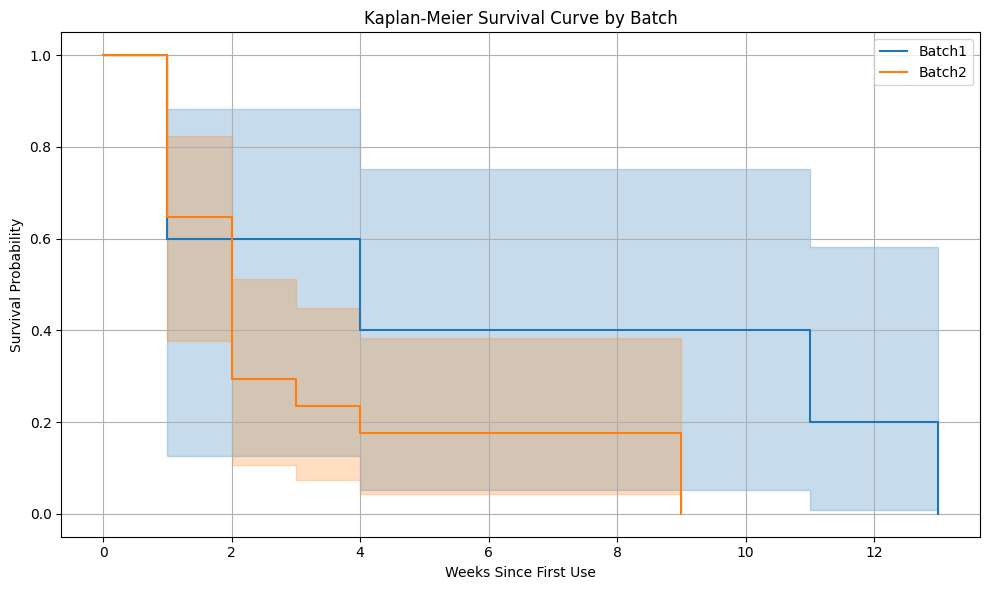

In [40]:
from lifelines import KaplanMeierFitter
import pickle

# ÏÑ§Ï†ï
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
BATCHES = ["Batch1", "Batch2"]
dropout_user_ids_batch1 = [f"cmp1_usr{uid}" for uid in [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]]
dropout_user_ids_batch2 = [f"cmp1_usr{uid}" for uid in [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]]
all_dropout_ids = dropout_user_ids_batch1 + dropout_user_ids_batch2
batch_map = {uid: "Batch1" for uid in dropout_user_ids_batch1}
batch_map.update({uid: "Batch2" for uid in dropout_user_ids_batch2})

# üîπ ÏÉùÏ°¥ Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
def prepare_survival_data(weekly_sample_map, dropout_ids):
    durations, events, batches, valid_ids = [], [], [], []
    for user_id in dropout_ids:
        week_data = weekly_sample_map.get(user_id, {})
        if not week_data:
            continue
        sorted_weeks = sorted(week_data.items())
        duration = 0
        for week, count in sorted_weeks:
            if count == 0:
                break
            duration = week + 1
        durations.append(duration)
        events.append(1)  # dropout occurred
        batches.append(batch_map[user_id])
        valid_ids.append(user_id)

    return pd.DataFrame({
        "user_id": valid_ids,
        "duration": durations,
        "event": events,
        "batch": batches
    })

# Í∏∞Ï°¥Ïùò weekly_sample_map ÏÉùÏÑ± ÏΩîÎìú ÏÇ¨Ïö© (Ïù¥ÎØ∏ ÏûëÏÑ±ÌïòÏÖ®Îçò Ìï®Ïàò)
weekly_sample_map = get_all_users_weekly_sample_count()

# üîπ Ï†ÄÏû•
with open(OUTPUT_PATH / "weekly_sample_map.pkl", "wb") as f:
    pickle.dump(weekly_sample_map, f)

print("‚úÖ weekly_sample_map.pkl Ï†ÄÏû• ÏôÑÎ£å")
# üîπ Load weekly_sample_map
#weekly_sample_map = pickle.load(open("./analysis_outputs/weekly_sample_map.pkl", "rb"))

# üîπ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
survival_df = prepare_survival_data(weekly_sample_map, all_dropout_ids)

# üîπ Kaplan-Meier Plot
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for batch in survival_df['batch'].unique():
    batch_df = survival_df[survival_df['batch'] == batch]
    kmf.fit(durations=batch_df["duration"], event_observed=batch_df["event"], label=batch)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve by Batch")
plt.xlabel("Weeks Since First Use")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

üìä Survival Data Summary:
        count      mean       std  min   25%   50%    75%   max
batch                                                          
Batch1   62.0  9.887097  3.711324  1.0  8.25  10.0  10.75  28.0
Batch2  102.0  9.058824  3.514675  1.0  9.00  10.0  10.00  20.0

üìä BatchÎ≥Ñ ÏÇ¨Ïö©Ïûê Ïàò Î∞è dropout ÎπÑÏú®:
event     1
batch      
Batch1  1.0
Batch2  1.0


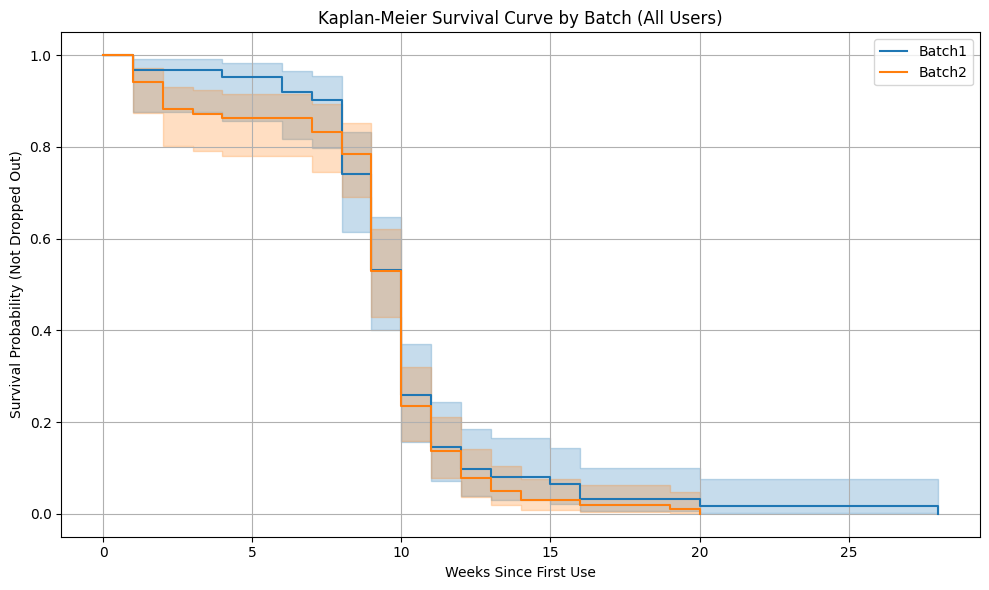

In [44]:
#Ï†ÑÏ≤¥ÏÇ¨Ïö©ÏûêÎ∂ÑÏÑù

# üîπ ÏÇ¨Ï†Ñ Ï†ïÏùò
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # 2016
BATCHES = ["Batch1", "Batch2"]
weekly_sample_map_path = Path("./analysis_outputs/weekly_sample_map.pkl")

# üîπ weekly_sample_map Î∂àÎü¨Ïò§Í∏∞
import pickle
with open(weekly_sample_map_path, "rb") as f:
    weekly_sample_map = pickle.load(f)

def prepare_survival_data(weekly_sample_map, user_ids=None):
    durations, events, batches, valid_ids = [], [], [], []

    if user_ids is None:
        user_ids = list(weekly_sample_map.keys())

    for user_id in user_ids:
        week_data = weekly_sample_map.get(user_id, {})
        if not week_data:
            continue

        sorted_weeks = sorted(week_data.items())
        weeks_with_data = [w for w, c in sorted_weeks if c > 0]
        if not weeks_with_data:
            continue

        last_week = max(weeks_with_data)
        all_weeks = {w for w, _ in sorted_weeks}
        after_last = sorted([w for w in all_weeks if w > last_week])

        # üîπ Ïù¥ÌÉà ÌåêÎã®: Ïù¥ÌõÑ Î™®Îì† Ï£ºÏóê ÏàòÏßëÎ•†Ïù¥ 0Ïù∏ Í≤ΩÏö∞Îßå dropoutÏúºÎ°ú Í∞ÑÏ£º
        dropped_out = all(week_data.get(w, 0) == 0 for w in after_last)

        durations.append(last_week + 1)
        events.append(1 if dropped_out else 0)
        valid_ids.append(user_id)
        batches.append(infer_batch(user_id))

    df = pd.DataFrame({
        "user_id": valid_ids,
        "duration": durations,
        "event": events,
        "batch": batches
    })

    print("üìä Survival Data Summary:")
    print(df.groupby('batch')['duration'].describe())
    print("\nüìä BatchÎ≥Ñ ÏÇ¨Ïö©Ïûê Ïàò Î∞è dropout ÎπÑÏú®:")
    print(df.groupby('batch')['event'].value_counts(normalize=True).unstack().round(2))
    return df

def infer_batch(user_id):
    num = int(user_id.split("usr")[-1])
    return "Batch1" if num < 660 else "Batch2"
# üîπ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
survival_df = prepare_survival_data(weekly_sample_map)

# üîπ Kaplan-Meier ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for batch in survival_df["batch"].unique():
    if batch == "Unknown":
        continue
    subset = survival_df[survival_df["batch"] == batch]
    kmf.fit(durations=subset["duration"], event_observed=subset["event"], label=batch)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve by Batch (All Users)")
plt.xlabel("Weeks Since First Use")
plt.ylabel("Survival Probability (Not Dropped Out)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Dropout users Weekly data submission rate

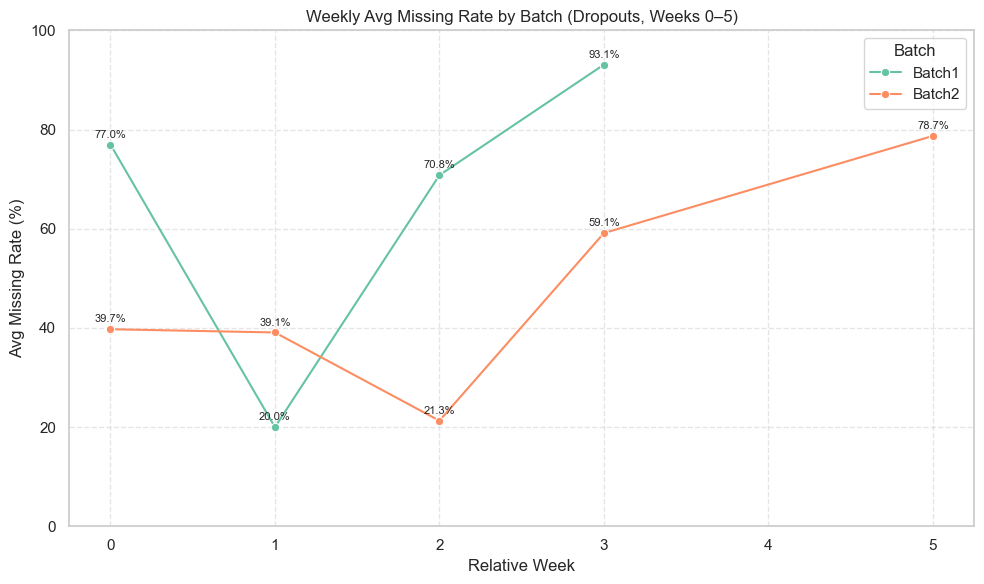

‚ñ∂ Dropout Users' Weekly Missing Rate Stats (Weeks 0‚Äì5):

             count   mean    std    min    25%    50%    75%    max
Week Batch                                                         
0    Batch1    5.0  76.98  23.38  47.57  57.29  84.28  96.18  99.60
     Batch2   17.0  39.74  44.65   0.00   0.35   2.98  92.81  99.75
1    Batch1    2.0  19.99  25.18   2.18  11.09  19.99  28.89  37.80
     Batch2    9.0  39.08  37.40   0.05   1.34  27.88  73.26  93.11
2    Batch1    2.0  70.81  14.98  60.22  65.51  70.81  76.10  81.40
     Batch2    3.0  21.28  17.69   1.64  13.94  26.24  31.10  35.96
3    Batch1    2.0  93.11   9.68  86.26  89.68  93.11  96.53  99.95
     Batch2    1.0  59.13    NaN  59.13  59.13  59.13  59.13  59.13
5    Batch2    1.0  78.72    NaN  78.72  78.72  78.72  78.72  78.72


In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_SAMPLES_PER_WEEK = (7 * 24 * 60) // 5  # = 2016
sns.set(style="whitegrid")

batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_users = [f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids]

def build_dropout_weekly_records():
    recs = []
    for uid in dropout_users:
        num = int(uid.replace("cmp1_usr",""))
        batch = "Batch1" if num in batch1_ids else "Batch2"
        fp = BASE_PATH/batch/uid/SENSOR_FOLDER/SENSOR_FILE
        if not fp.exists(): continue
        df = pd.read_csv(fp, usecols=["timestamp"])
        df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
        if df.empty: continue
        start = df["ts"].min()
        df["week"] = ((df["ts"]-start).dt.days//7).astype(int)
        def count_valid(xs):
            xs = xs.sort_values().reset_index(drop=True)
            last, cnt = xs.iloc[0], 1
            for x in xs.iloc[1:]:
                if (x-last).total_seconds()>=300:
                    cnt+=1; last=x
            return cnt
        wc = df.groupby("week")["ts"].apply(count_valid).to_dict()
        for wk,cnt in wc.items():
            recs.append({
                "Batch": batch,
                "Week": wk,
                "MissingRate": (1 - cnt/EXPECTED_SAMPLES_PER_WEEK)*100
            })
    return pd.DataFrame(recs)

# ‚îÄ‚îÄ‚îÄ Ïã§Ìñâ & Ï†ÑÏ≤òÎ¶¨ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = build_dropout_weekly_records()
df6 = df[df["Week"].between(0,5)].copy()   # Week0~5

# ‚îÄ‚îÄ‚îÄ (A) ÏãúÍ∞ÅÌôî ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(10, 6))
sns.lineplot(data=df6.groupby(["Batch","Week"])["MissingRate"].mean().reset_index(),
             x="Week",y="MissingRate",hue="Batch",marker="o",palette="Set2")
for _, row in df6.groupby(["Batch","Week"])["MissingRate"].mean().reset_index().iterrows():
    plt.text(row["Week"], row["MissingRate"]+1, f"{row['MissingRate']:.1f}%",
             ha="center",va="bottom",fontsize=8)
plt.title("Weekly Avg Missing Rate by Batch (Dropouts, Weeks 0‚Äì5)")
plt.xlabel("Relative Week")
plt.ylabel("Avg Missing Rate (%)")
plt.ylim(0,100); plt.xticks(range(0,6))
plt.grid(True,linestyle="--",alpha=0.5); plt.legend(title="Batch")
plt.tight_layout(); plt.show()

# ‚îÄ‚îÄ‚îÄ (B) Batch√óWeekÎ≥Ñ Í∏∞Ïà†ÌÜµÍ≥ÑÎüâ Ï∂úÎ†• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
stats = (
    df6
    .groupby(["Week","Batch"])["MissingRate"]
    .describe(percentiles=[.25,.5,.75])
    .loc[:, ["count","mean","std","min","25%","50%","75%","max"]]
    .round(2)
)
print("‚ñ∂ Dropout Users' Weekly Missing Rate Stats (Weeks 0‚Äì5):\n")
print(stats)

### ÌöåÎ≥µÏûê Î∂ÑÏÑù

In [57]:
import pandas as pd
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"

# Dropout ÏÇ¨Ïö©Ïûê ID Î¶¨Ïä§Ìä∏
batch1_ids = [542, 584, 597, 601, 608, 613, 617, 618, 621, 631, 639, 645]
batch2_ids = [662, 663, 666, 669, 682, 683, 689, 701, 704, 716, 723, 725,
              726, 727, 736, 746, 756, 765, 767, 769]
dropout_users = {f"cmp1_usr{uid}" for uid in batch1_ids + batch2_ids}

# Batch ÌåêÏ†ï
def infer_batch(uid):
    num = int(uid.replace("cmp1_usr", ""))
    return "Batch1" if num < 654 else "Batch2"

# ‚îÄ‚îÄ‚îÄ 5Î∂Ñ ÌïÑÌÑ∞ÎßÅ Ìè¨Ìï® Ï£ºÏ∞®Î≥Ñ ÏÉòÌîå Ïàò Îßµ ÏÉùÏÑ± ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def build_weekly_sample_map():
    user_week_map = {}
    for batch in ["Batch1","Batch2"]:
        for uf in (BASE_PATH/batch).glob("cmp1_usr*"):
            uid = uf.name
            path = uf/SENSOR_FOLDER/SENSOR_FILE
            if not path.exists():
                user_week_map[uid] = {}
                continue
            df = pd.read_csv(path, usecols=["timestamp"])
            if df.empty:
                user_week_map[uid] = {}
                continue
            df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
            if df.empty:
                user_week_map[uid] = {}
                continue
            start = df["ts"].min()
            df["week"] = ((df["ts"]-start).dt.days//7).astype(int)
            def count_valid(xs):
                xs = xs.sort_values().reset_index(drop=True)
                last, cnt = xs.iloc[0], 1
                for x in xs.iloc[1:]:
                    if (x-last).total_seconds() >= 300:
                        cnt += 1
                        last = x
                return cnt
            user_week_map[uid] = df.groupby("week")["ts"].apply(count_valid).to_dict()
    return user_week_map

weekly_map = build_weekly_sample_map()

# ‚îÄ‚îÄ‚îÄ 1) Dropout Ïù¥ÌõÑ Î≥µÍ∑Ä ÌÉêÏßÄ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
rec1 = []
for uid in sorted(dropout_users, key=lambda u: int(u.replace("cmp1_usr",""))):
    weeks = weekly_map.get(uid, {})
    if not weeks:
        drop_w = 0
        recovered = False
    else:
        max_w = max(weeks.keys())
        # 0~max_w ÏÇ¨Ïù¥ÏóêÏÑú Ï≤´ 0Ï£ºÏ∞®
        drop_w = next((w for w in range(max_w+1) if weeks.get(w,0)==0), None)
        # Ïù¥ÌõÑ ÏïÑÎ¨¥ÎïåÎÇò Î≥µÍ∑Ä
        recovered = (drop_w is not None) and any(weeks.get(w,0)>0 for w in range(drop_w+1, max_w+1))
    rec1.append({
        "User": uid,
        "Batch": infer_batch(uid),
        "DropoutWeek": drop_w,
        "RecoveredAfterDropout": recovered
    })
df_recover1 = pd.DataFrame(rec1)

# ‚îÄ‚îÄ‚îÄ 2) Non-Dropout Ï§ë ÏùºÏãúÏ†Å 0% ÌõÑ Î≥µÍ∑Ä ÌÉêÏßÄ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
rec2 = []
for uid, weeks in weekly_map.items():
    if uid in dropout_users:
        continue
    if not weeks:
        zero_w = None
        recovered = False
    else:
        max_w = max(weeks.keys())
        zero_w = None
        recovered = False
        for w in range(max_w+1):
            if weeks.get(w,0)==0:
                # Ïù¥ÌõÑ ÏïÑÎ¨¥ÎïåÎÇò Î≥µÍ∑Ä
                if any(weeks.get(x,0)>0 for x in range(w+1, max_w+1)):
                    zero_w = w
                    recovered = True
                    break
    rec2.append({
        "User": uid,
        "Batch": infer_batch(uid),
        "ZeroWeek": zero_w,
        "RecoveredAfterZero": recovered
    })
df_recover2 = pd.DataFrame(rec2)

# ‚îÄ‚îÄ‚îÄ Í≤∞Í≥º ÏßëÍ≥Ñ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1) Dropout Users
print("1) Dropout Users Recovery After Dropout:")
print(
    df_recover1
      .groupby("Batch")["RecoveredAfterDropout"]
      .value_counts()
      .unstack(fill_value=0)
, "\n")

# 2) Non-Dropout Users
summary2 = (
    df_recover2
      .groupby("Batch")["RecoveredAfterZero"]
      .value_counts()
      .unstack(fill_value=0)
)

# Batch1, Batch2Í∞Ä Ìï≠ÏÉÅ Î≥¥Ïù¥ÎèÑÎ°ù Ïû¨ÏÉâÏù∏
summary2 = summary2.reindex(index=["Batch1","Batch2"], fill_value=0)

print("2) Non-Dropout Users Zero->Recovered:")
print(summary2)
# ÌïÑÏöîÏãú ÏóëÏÖÄ Ï†ÄÏû•
# df_recover1.to_excel("recover_after_dropout.xlsx", index=False)
# df_recover2.to_excel("recover_after_zero.xlsx", index=False)

1) Dropout Users Recovery After Dropout:
RecoveredAfterDropout  False  True 
Batch                              
Batch1                    10      2
Batch2                    17      3 

2) Non-Dropout Users Zero->Recovered:
RecoveredAfterZero  False  True 
Batch                           
Batch1                 43     11
Batch2                 76     12


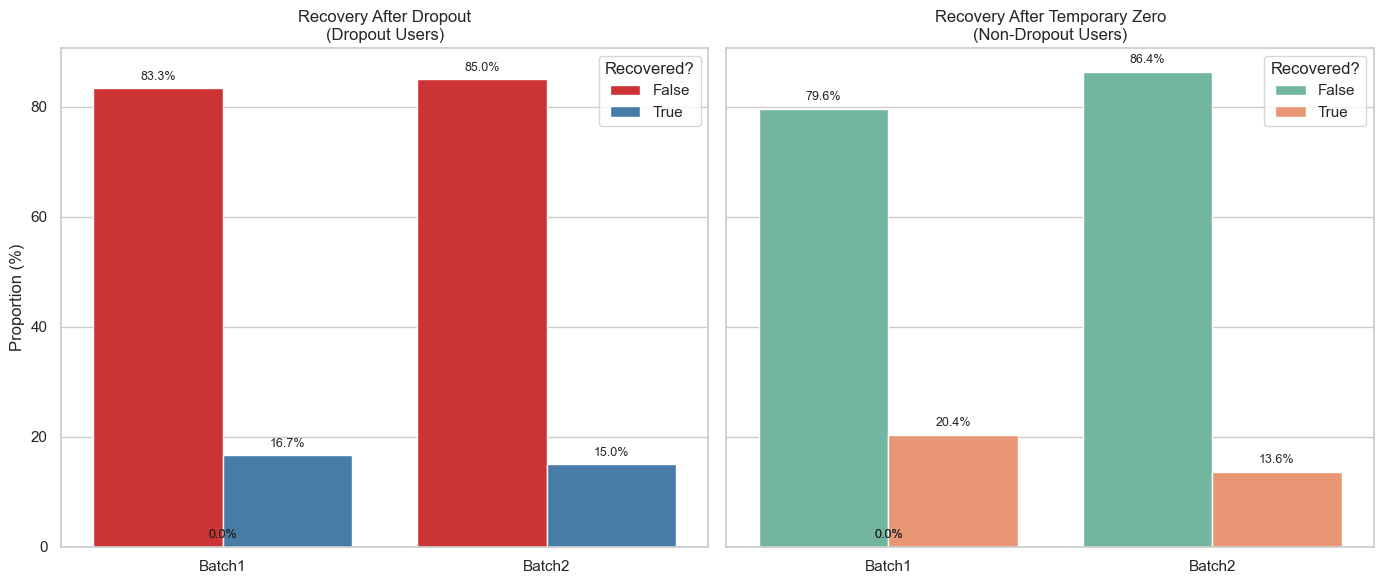

In [58]:
sns.set(style="whitegrid")

# ‚îÄ‚îÄ‚îÄ (1) Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# df_recover1, df_recover2 Îäî ÏïûÏóêÏÑú ÎßåÎì† DataFrame Ïù¥ÎùºÍ≥† Í∞ÄÏ†ïÌï©ÎãàÎã§.

# 1) Dropout Users Recovery
summary1 = (
    df_recover1
      .groupby(["Batch","RecoveredAfterDropout"])
      .size()
      .reset_index(name="Count")
)
# Î∞∞ÏπòÎ≥Ñ Ï†ÑÏ≤¥ Ïàò
summary1["Total"] = summary1.groupby("Batch")["Count"].transform("sum")
# ÎπÑÏú® Í≥ÑÏÇ∞
summary1["Pct"] = summary1["Count"] / summary1["Total"] * 100

# 2) Non-Dropout Temporary Zero-Recovery
summary2 = (
    df_recover2
      .groupby(["Batch","RecoveredAfterZero"])
      .size()
      .reset_index(name="Count")
)
summary2["Total"] = summary2.groupby("Batch")["Count"].transform("sum")
summary2["Pct"] = summary2["Count"] / summary2["Total"] * 100

# ‚îÄ‚îÄ‚îÄ (2) ÏãúÍ∞ÅÌôî ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# 1) Dropout Users
sns.barplot(
    data=summary1,
    x="Batch", y="Pct", hue="RecoveredAfterDropout",
    palette="Set1", ax=axes[0]
)
axes[0].set_title("Recovery After Dropout\n(Dropout Users)")
axes[0].set_ylabel("Proportion (%)")
axes[0].set_xlabel("")
for p in axes[0].patches:
    h = p.get_height()
    axes[0].text(
        p.get_x()+p.get_width()/2, h+1,
        f"{h:.1f}%", ha="center", va="bottom", fontsize=9
    )

# 2) Non-Dropout Users
sns.barplot(
    data=summary2,
    x="Batch", y="Pct", hue="RecoveredAfterZero",
    palette="Set2", ax=axes[1]
)
axes[1].set_title("Recovery After Temporary Zero\n(Non-Dropout Users)")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
for p in axes[1].patches:
    h = p.get_height()
    axes[1].text(
        p.get_x()+p.get_width()/2, h+1,
        f"{h:.1f}%", ha="center", va="bottom", fontsize=9
    )

# Î≤îÎ°Ä Ï†úÎ™© Ï°∞Ï†ï
axes[0].legend(title="Recovered?")
axes[1].legend(title="Recovered?")

plt.tight_layout()
plt.show()

### Avg. Data Submission Rate

    Batch  TotalUsers  NumAbove  PctAbove (%)
0  Batch1          66        49     74.242424
1  Batch2         108        77     71.296296


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/922766837.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


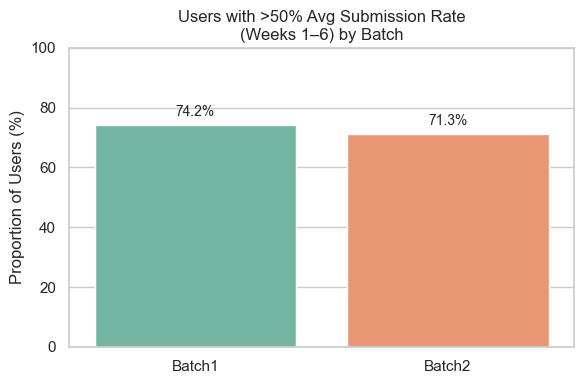

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
xlsx = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# Dropout Î¶¨Ïä§Ìä∏ (ÌïÑÌÑ∞ÎßÅÏùÄ Ïó¨Í∏∞ÏÑ† Î∂àÌïÑÏöî‚ÄîÏ†ÑÏ≤¥ Ïú†Ï†Ä ÎåÄÏÉÅÏúºÎ°ú)
#drop1 = [542,584,597,601,608,613,617,618,621,631,639,645]
#drop2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
drop1 = []
drop2 = []
dropout = {f"cmp1_usr{u}" for u in drop1+drop2}

# ‚îÄ‚îÄ‚îÄ 1) ÏóëÏÖÄ ÏùΩÍ∏∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(xlsx, index_col=0)

# ‚îÄ‚îÄ‚îÄ 2) Ï£ºÏ∞® Ïª¨Îüº(Ïà´Ïûê)Îßå Í≥®Îùº Ï†ïÏàòÌòïÏúºÎ°ú Î≥ÄÌôò ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
week_cols = sorted(int(c) for c in df.columns if str(c).isdigit())

# ‚îÄ‚îÄ‚îÄ 3) 0~6Ï£ºÏ∞®Îßå ÏÑ†ÌÉùÌï¥ÏÑú ÌèâÍ∑† Ï†úÏ∂úÎ•† Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
selected_weeks = [w for w in week_cols if w <= 5]
df["AvgRate_0_6"] = df[selected_weeks].mean(axis=1)

# ‚îÄ‚îÄ‚îÄ 4) Batch Ïª¨Îüº Ï∂îÍ∞Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr",""))
    return "Batch1" if n < 654 else "Batch2"

df["Batch"] = df.index.to_series().apply(infer_batch)

# ‚îÄ‚îÄ‚îÄ 5) 50% Ï¥àÍ≥º Ïú†Ï†Ä ÌîåÎûòÍ∑∏ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
cutoff = 50.0
df["Above50_0_6"] = df["AvgRate_0_6"] > cutoff

# ‚îÄ‚îÄ‚îÄ 6) Î∞∞ÏπòÎ≥Ñ ÌÜµÍ≥Ñ ÏßëÍ≥Ñ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
summary = (
    df
      .groupby("Batch")["Above50_0_6"]
      .agg(TotalUsers="count", NumAbove="sum")
      .reset_index()
)
summary["PctAbove (%)"] = summary["NumAbove"] / summary["TotalUsers"] * 100

print(summary)

# ‚îÄ‚îÄ‚îÄ 7) ÏãúÍ∞ÅÌôî ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))

# ÎπÑÏú® ÎßâÎåÄÍ∑∏ÎûòÌîÑ
ax = sns.barplot(
    data=summary,
    x="Batch", y="PctAbove (%)",
    palette=["#66C2A5", "#FC8D62"]
)

# Í∞Å ÎßâÎåÄ ÏúÑÏóê Ïã§Ï†ú ÌçºÏÑºÌä∏ ÌëúÏãú
for i, row in summary.iterrows():
    ax.text(
        i, row["PctAbove (%)"] + 2,
        f"{row['PctAbove (%)']:.1f}%",
        ha="center", va="bottom", fontsize=10
    )

plt.ylim(0, 100)
plt.title("Users with >50% Avg Submission Rate\n(Weeks 1‚Äì6) by Batch")
plt.ylabel("Proportion of Users (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

‚ñ∂ ÎßàÏßÄÎßâ Ï†úÏ∂ú Ï£ºÏ∞®ÍπåÏßÄ ÌèâÍ∑† Ï†úÏ∂úÎ•†Ïù¥ 30% Ï¥àÍ≥ºÏù∏ ÏÇ¨Ïö©Ïûê ÎπÑÏú® (Î∞∞ÏπòÎ≥Ñ):
 Batch  TotalUsers  NumAbove  PctAbove (%)
Batch1          66        47          71.2
Batch2         108        86          79.6


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/1743461091.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


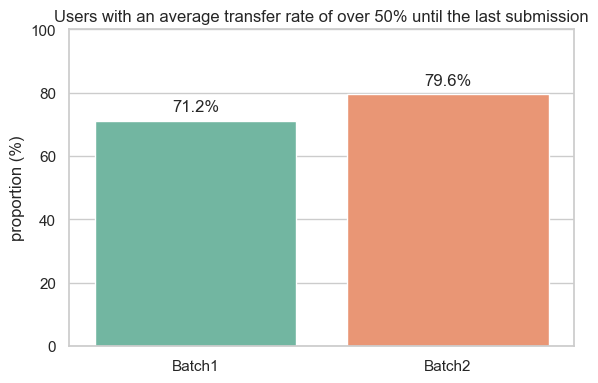

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# 1) ÏóëÏÖÄ Î∂àÎü¨Ïò§Í∏∞
xlsx = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")
df = pd.read_excel(xlsx, index_col=0)

# 2) Ïª¨ÎüºÎ™ÖÏùÑ Ï†ïÏàòÌòï Ï£ºÏ∞®Î°ú Î≥ÄÌôò
#    Ïòà: Ïª¨ÎüºÏù¥ Î™®Îëê '0','1',‚Ä¶ ÌòïÌÉúÎùºÎ©¥ intÎ°ú Î∞îÍøîÏ§çÎãàÎã§.
df.columns = [int(c) for c in df.columns if str(c).isdigit()]
week_cols = sorted(df.columns)

# 3) ÎßàÏßÄÎßâ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï£ºÏ∞®ÍπåÏßÄ ÌèâÍ∑† Ï†úÏ∂úÎ•† Í≥ÑÏÇ∞ Ìï®Ïàò
def avg_until_last_positive(row):
    # Ï†úÏ∂úÎ•† > 0Ïù∏ Ï£ºÏ∞® Ï∞æÍ∏∞
    positive_weeks = [w for w in week_cols if row[w] > 0]
    if not positive_weeks:
        return 0.0
    last = max(positive_weeks)
    # 0Ï£ºÏ∞®Î∂ÄÌÑ∞ lastÏ£ºÏ∞®ÍπåÏßÄ Ïª¨Îüº Î¶¨Ïä§Ìä∏
    cols = list(range(0, last + 1))
    return row[cols].mean()

df["AvgRate_UntilLast"] = df.apply(avg_until_last_positive, axis=1)

# 4) Batch Ï†ïÎ≥¥ Ï∂îÍ∞Ä
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr", ""))
    return "Batch1" if n < 654 else "Batch2"

df["Batch"] = df.index.to_series().apply(infer_batch)

# 5) Ïª∑Ïò§ÌîÑ ÌîåÎûòÍ∑∏ ÏÑ§Ï†ï (Ïòà: 30%)
cutoff = 50.0
df["Above30"] = df["AvgRate_UntilLast"] > cutoff

# 6) Î∞∞ÏπòÎ≥Ñ ÏßëÍ≥Ñ
summary = (
    df
      .groupby("Batch")["Above30"]
      .agg(TotalUsers="count", NumAbove="sum")
      .reset_index()
)
summary["PctAbove (%)"] = (summary["NumAbove"] / summary["TotalUsers"] * 100).round(1)

print("‚ñ∂ ÎßàÏßÄÎßâ Ï†úÏ∂ú Ï£ºÏ∞®ÍπåÏßÄ ÌèâÍ∑† Ï†úÏ∂úÎ•†Ïù¥ 30% Ï¥àÍ≥ºÏù∏ ÏÇ¨Ïö©Ïûê ÎπÑÏú® (Î∞∞ÏπòÎ≥Ñ):")
print(summary.to_string(index=False))

# 7) ÏãúÍ∞ÅÌôî
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=summary,
    x="Batch", y="PctAbove (%)",
    palette=["#66C2A5", "#FC8D62"]
)
for i, row in summary.iterrows():
    ax.text(i, row["PctAbove (%)"] + 2,
            f"{row['PctAbove (%)']:.1f}%",
            ha="center", va="bottom")
plt.ylim(0,100)
plt.title("Users with an average transfer rate of over 50% until the last submission")
plt.ylabel("proportion (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

‚ñ∂ Dropout Ï†úÏô∏ ÌõÑ, ÎßàÏßÄÎßâ Ï†úÏ∂ú Ï£ºÏ∞®ÍπåÏßÄ ÌèâÍ∑† Ï†úÏ∂úÎ•†Ïù¥ 30% Ï¥àÍ≥ºÏù∏ ÏÇ¨Ïö©Ïûê ÎπÑÏú® (Î∞∞ÏπòÎ≥Ñ):
 Batch  TotalUsers  NumAbove  PctAbove (%)
Batch1          54        15          27.8
Batch2          88        34          38.6


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/3680251306.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


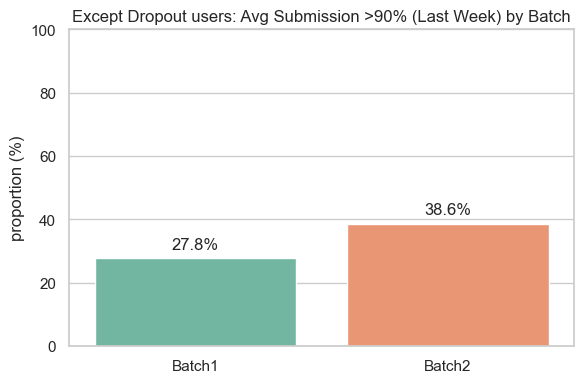

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1) ÏÑ§Ï†ï
xlsx = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# 2) ÎìúÎ°≠ÏïÑÏõÉ ÏÇ¨Ïö©Ïûê ID Î¶¨Ïä§Ìä∏
drop1 = [542,584,597,601,608,613,617,618,621,631,639,645]
drop2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout = {f"cmp1_usr{u}" for u in drop1 + drop2}

# 3) ÏóëÏÖÄ Î∂àÎü¨Ïò§Í∏∞ & Ï£ºÏ∞® Ïª¨Îüº Ï∂îÏ∂ú
df = pd.read_excel(xlsx, index_col=0)
week_cols = sorted(int(c) for c in df.columns if str(c).isdigit())
# Ïª¨ÎüºÎ™ÖÏùÑ Ï†ïÏàòÎ°ú Î∞îÍøîÎëêÎ©¥ Ï†ëÍ∑ºÏù¥ Ìé∏Ìï©ÎãàÎã§
df.columns = week_cols

# 4) Dropout ÏÇ¨Ïö©Ïûê Ï†úÏô∏
df = df.loc[~df.index.isin(dropout)]

# 5) ÎßàÏßÄÎßâ Ï†úÏ∂ú Ï£ºÏ∞®ÍπåÏßÄ ÌèâÍ∑† Ï†úÏ∂úÎ•† Í≥ÑÏÇ∞
def avg_until_last_positive(row):
    positive_weeks = [w for w in week_cols if row[w] > 0]
    if not positive_weeks:
        return 0.0
    last = max(positive_weeks)
    return row[list(range(0, last+1))].mean()

df["AvgRate_UntilLast"] = df.apply(avg_until_last_positive, axis=1)

# 6) Batch Ï†ïÎ≥¥ Ï∂îÍ∞Ä
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr",""))
    return "Batch1" if n < 654 else "Batch2"
df["Batch"] = df.index.to_series().apply(infer_batch)

# 7) Ïª∑Ïò§ÌîÑ ÌîåÎûòÍ∑∏ (Ïòà: 30%)
cutoff = 90.0
df["Above30"] = df["AvgRate_UntilLast"] > cutoff

# 8) Î∞∞ÏπòÎ≥Ñ ÏßëÍ≥Ñ
summary = (
    df
      .groupby("Batch")["Above30"]
      .agg(TotalUsers="count", NumAbove="sum")
      .reset_index()
)
summary["PctAbove (%)"] = (summary["NumAbove"] / summary["TotalUsers"] * 100).round(1)

print("‚ñ∂ Dropout Ï†úÏô∏ ÌõÑ, ÎßàÏßÄÎßâ Ï†úÏ∂ú Ï£ºÏ∞®ÍπåÏßÄ ÌèâÍ∑† Ï†úÏ∂úÎ•†Ïù¥ 30% Ï¥àÍ≥ºÏù∏ ÏÇ¨Ïö©Ïûê ÎπÑÏú® (Î∞∞ÏπòÎ≥Ñ):")
print(summary.to_string(index=False))

# 9) ÏãúÍ∞ÅÌôî
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=summary,
    x="Batch", y="PctAbove (%)",
    palette=["#66C2A5", "#FC8D62"]
)
for i, row in summary.iterrows():
    ax.text(i, row["PctAbove (%)"] + 2,
            f"{row['PctAbove (%)']:.1f}%",
            ha="center", va="bottom")
plt.ylim(0,100)
plt.title("Except Dropout users: Avg Submission >90% (Last Week) by Batch")
plt.ylabel("proportion (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

### Ï†ÑÏ≤¥ ÏÇ¨Ïö©Í∏∞Í∞Ñ for Non-Dropout Users

‚ñ∂ Sample of result:
          User   Batch  LastWeek  WeeksWithData
0  cmp1_usr541  Batch1         9             10
1  cmp1_usr545  Batch1         5              6
2  cmp1_usr546  Batch1        15             16
3  cmp1_usr547  Batch1        11             12
4  cmp1_usr559  Batch1         6              7 

‚ñ∂ Descriptive statistics by Batch:
Batch                   Batch1     Batch2
LastWeek      count  57.000000  85.000000
              mean    9.228070   9.258824
              std     3.354195   2.110929
              min     5.000000   6.000000
              25%     8.000000   8.000000
              50%     9.000000   9.000000
              75%     9.000000  10.000000
              max    27.000000  19.000000
WeeksWithData count  57.000000  85.000000
              mean    9.894737  10.070588
              std     2.643619   1.956602
              min     6.000000   6.000000
              25%     8.000000   9.000000
              50%     9.000000  10.000000
              75%    

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")


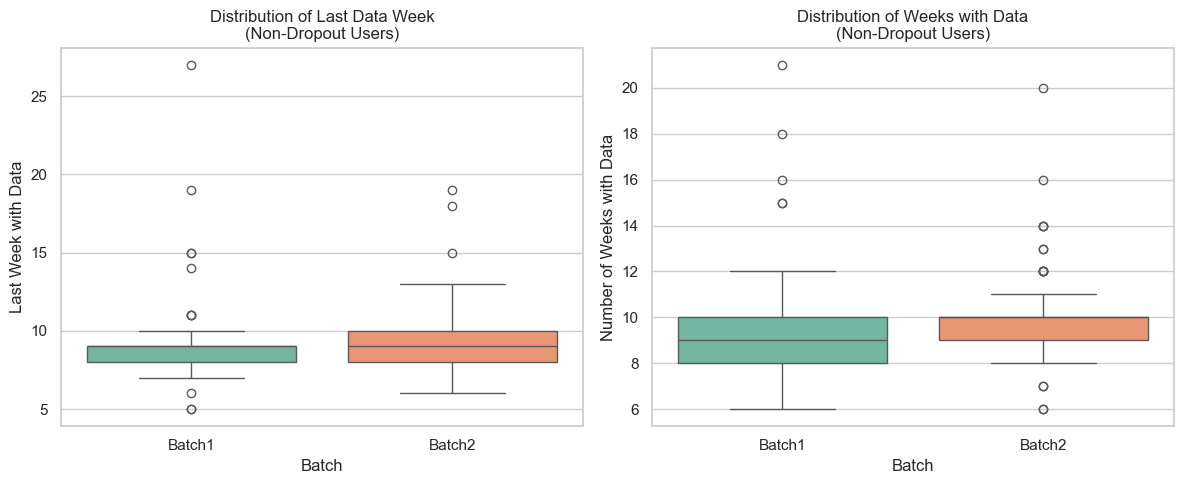

/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/569969948.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")


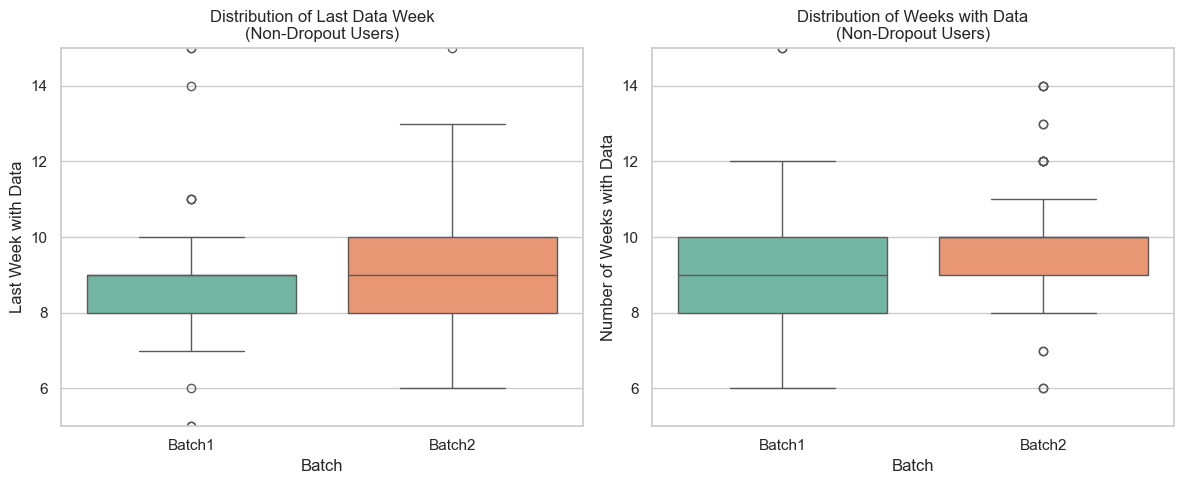

üìä Descriptive Statistics by Batch:
       LastWeek                                        WeeksWithData         \
          count  mean   std  min  25%  50%   75%   max         count   mean   
Batch                                                                         
Batch1     57.0  9.23  3.35  5.0  8.0  9.0   9.0  27.0          57.0   9.89   
Batch2     85.0  9.26  2.11  6.0  8.0  9.0  10.0  19.0          85.0  10.07   

                                          
         std  min  25%   50%   75%   max  
Batch                                     
Batch1  2.64  6.0  8.0   9.0  10.0  21.0  
Batch2  1.96  6.0  9.0  10.0  10.0  20.0  


In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
xlsx_path = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# Dropout ÏÇ¨Ïö©Ïûê ID Î¶¨Ïä§Ìä∏
batch1_ids = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_ids = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout = {f"cmp1_usr{u}" for u in batch1_ids + batch2_ids}

# ‚îÄ‚îÄ‚îÄ 1) ÏóëÏÖÄ Î∂àÎü¨Ïò§Í∏∞ & Ï£ºÏ∞® Ïª¨Îüº ÏãùÎ≥Ñ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(xlsx_path, index_col=0)
week_cols = sorted(int(c) for c in df.columns if str(c).isdigit())
df.columns = week_cols

# ‚îÄ‚îÄ‚îÄ 2) Non-Dropout Users ÌïÑÌÑ∞ÎßÅ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
non_do = [uid for uid in df.index if uid not in dropout]
nd_df = df.loc[non_do].copy()

# ‚îÄ‚îÄ‚îÄ 3) Batch Ïª¨Îüº Ï∂îÍ∞Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def infer_batch(uid):
    n = int(uid.replace("cmp1_usr",""))
    return "Batch1" if n < 660 else "Batch2"

nd_df["Batch"] = nd_df.index.to_series().apply(infer_batch)

# ‚îÄ‚îÄ‚îÄ 4) Ï†ÑÏ≤¥ ÏÇ¨Ïö© Í∏∞Í∞Ñ: ÎßàÏßÄÎßâ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï£ºÏ∞® ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def calc_last_week(row):
    weeks_with_data = [w for w, val in zip(week_cols, row[week_cols]) if val > 0]
    return max(weeks_with_data) if weeks_with_data else np.nan

nd_df["LastWeek"] = nd_df.apply(calc_last_week, axis=1)

# ‚îÄ‚îÄ‚îÄ 5) Îç∞Ïù¥ÌÑ∞ ÏàòÏßëÏù¥ ÏûàÎäî Ï£ºÏ∞®Îßå ÏÇ¨Ïö©: Ï£ºÏ∞® Ïàò Í≥ÑÏÇ∞ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
nd_df["WeeksWithData"] = (nd_df[week_cols] > 0).sum(axis=1)

# ‚îÄ‚îÄ‚îÄ 6) Í≤∞Í≥º ÌôïÏù∏ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
result = nd_df[["Batch", "LastWeek", "WeeksWithData"]].reset_index().rename(columns={"index":"User"})
print("‚ñ∂ Sample of result:")
print(result.head(), "\n")

# ‚îÄ‚îÄ‚îÄ 7) Î∞∞ÏπòÎ≥Ñ Í∏∞Ïà† ÌÜµÍ≥Ñ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
stats = result.groupby("Batch")[["LastWeek","WeeksWithData"]].describe().T
print("‚ñ∂ Descriptive statistics by Batch:")
print(stats)

# ‚îÄ‚îÄ‚îÄ 8) ÏãúÍ∞ÅÌôî ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=False)

# (1) LastWeek Î∂ÑÌè¨
sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
axes[0].set_title("Distribution of Last Data Week\n(Non-Dropout Users)")
axes[0].set_ylabel("Last Week with Data")

# (2) WeeksWithData Î∂ÑÌè¨
sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")
axes[1].set_title("Distribution of Weeks with Data\n(Non-Dropout Users)")
axes[1].set_ylabel("Number of Weeks with Data")

plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# (1) LastWeek Î∂ÑÌè¨
sns.boxplot(data=result, x="Batch", y="LastWeek", ax=axes[0], palette="Set2")
axes[0].set_title("Distribution of Last Data Week\n(Non-Dropout Users)")
axes[0].set_ylabel("Last Week with Data")
axes[0].set_ylim(5, 15)  # ÌïÑÏöîÏãú Ï†ÅÏ†àÌûà Ï°∞Ï†ï

# (2) WeeksWithData Î∂ÑÌè¨
sns.boxplot(data=result, x="Batch", y="WeeksWithData", ax=axes[1], palette="Set2")
axes[1].set_title("Distribution of Weeks with Data\n(Non-Dropout Users)")
axes[1].set_ylabel("Number of Weeks with Data")
axes[1].set_ylim(5, 15)  # ÌïÑÏöîÏãú Ï†ÅÏ†àÌûà Ï°∞Ï†ï

plt.tight_layout()
plt.show()

# üîπ BatchÎ≥Ñ Í∏∞Ï¥à ÌÜµÍ≥ÑÎüâ Í≥ÑÏÇ∞
summary_stats = (
    result
    .groupby("Batch")[["LastWeek", "WeeksWithData"]]
    .describe()
    .round(2)
)

# üîπ Î≥¥Í∏∞ ÏâΩÍ≤å Ìè¨Îß∑ÌåÖ
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print("üìä Descriptive Statistics by Batch:")
    print(summary_stats)

Batch1: 66it [00:03, 17.88it/s]
Batch2: 108it [00:05, 19.90it/s]
/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/12631753.py:77: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


‚ñ∂ Weekly Missing Rate Stats (Dropouts Excluded)

       count          mean           std       
Batch Batch1 Batch2 Batch1 Batch2 Batch1 Batch2
Week                                           
0       54.0   88.0  13.85  16.64  24.48  23.78
1       54.0   88.0  15.97  18.15  25.58  24.64
2       54.0   88.0  15.62  16.22  24.69  23.87
3       54.0   88.0  16.43  18.19  26.70  26.49
4       54.0   88.0  16.04  20.41  27.24  27.49
5       54.0   88.0  22.42  19.10  30.57  28.09


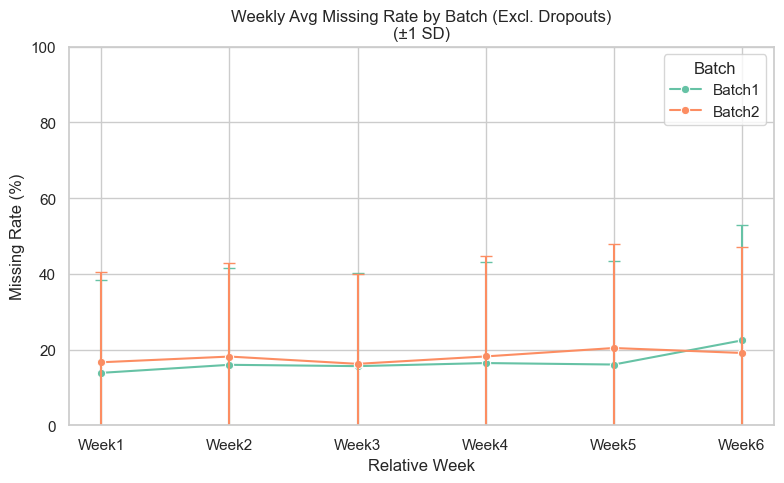

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE_PATH = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1","Batch2"]
SENSOR_FOLDER = "source_12"
SENSOR_FILE = "data_source_12.csv"
EXPECTED_PER_WEEK = (7*24*60)//5  # =2016
MAX_REL_WEEK = 6  # 0~5
sns.set(style="whitegrid")

# ÎìúÎ°≠ÏïÑÏõÉ ÏÇ¨Ïö©Ïûê ÏßëÌï©
batch1 = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropouts = {f"cmp1_usr{u}" for u in batch1+batch2}

# ‚îÄ‚îÄ‚îÄ 1) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ïû¨Î≤†Ïù¥Ïä§ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
records = []
for batch in BATCHES:
    for usr_dir in tqdm((BASE_PATH/batch).glob("cmp1_usr*"), desc=batch):
        uid = usr_dir.name
        if uid in dropouts:  # ÎìúÎ°≠ÏïÑÏõÉ Ï†úÏô∏
            continue
        fp = usr_dir/SENSOR_FOLDER/SENSOR_FILE
        if not fp.exists():
            continue

        df = pd.read_csv(fp, usecols=["timestamp"])
        df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.dropna(subset=["ts"]).drop_duplicates(["ts"])
        if df.empty:
            continue

        first_ts = df["ts"].min()
        df["week_offset"] = ((df["ts"] - first_ts).dt.days // 7).astype(int)

        def count_valid(series):
            s = series.sort_values().reset_index(drop=True)
            last, cnt = s.iloc[0], 1
            for t in s.iloc[1:]:
                if (t - last).total_seconds() >= 300:
                    cnt += 1
                    last = t
            return cnt

        wk_counts = df.groupby("week_offset")["ts"].apply(count_valid).to_dict()

        for w in range(MAX_REL_WEEK):
            cnt = wk_counts.get(w, 0)
            missing = 1 - cnt/EXPECTED_PER_WEEK
            records.append({
                "Batch": batch,
                "Week": w,  # Ïà´Ïûê 0~5
                "MissingRate": missing*100
            })

df_box = pd.DataFrame(records)

# ‚îÄ‚îÄ‚îÄ 2) ÌÜµÍ≥Ñ ÌÖåÏù¥Î∏î Ï∂úÎ†• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
stats = (
    df_box
    .groupby(["Week","Batch"])["MissingRate"]
    .agg(count="count", mean="mean", std="std")
    .round(2)
    .reset_index()
)
print("‚ñ∂ Weekly Missing Rate Stats (Dropouts Excluded)\n")
print(stats.pivot(index="Week", columns="Batch", values=["count","mean","std"]))

# ‚îÄ‚îÄ‚îÄ 3) Í∫æÏùÄÏÑ† Í∑∏ÎûòÌîÑ (mean ¬± std) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_box,
    x="Week", y="MissingRate", hue="Batch",
    ci=None, estimator=np.mean, marker="o", palette="Set2"
)

# ÏóêÎü¨Î∞î ÏßÅÏ†ë Ï∂îÍ∞Ä
for batch in BATCHES:
    df_b = stats[stats["Batch"]==batch]
    plt.errorbar(
        df_b["Week"], df_b["mean"],
        yerr=df_b["std"],
        fmt="none",
        capsize=4,
        color=sns.color_palette("Set2")[BATCHES.index(batch)]
    )

plt.xticks(range(MAX_REL_WEEK), [f"Week{w}" for w in range(1,MAX_REL_WEEK+1)])
plt.ylim(0, 100)
plt.title("Weekly Avg Missing Rate by Batch (Excl. Dropouts)\n(¬±1 SD)")
plt.xlabel("Relative Week")
plt.ylabel("Missing Rate (%)")
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

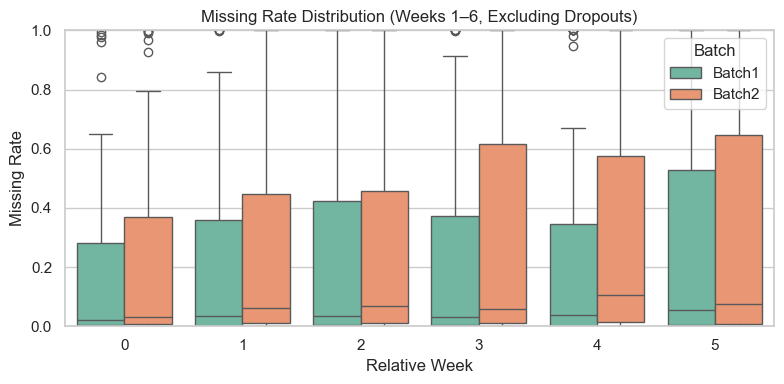

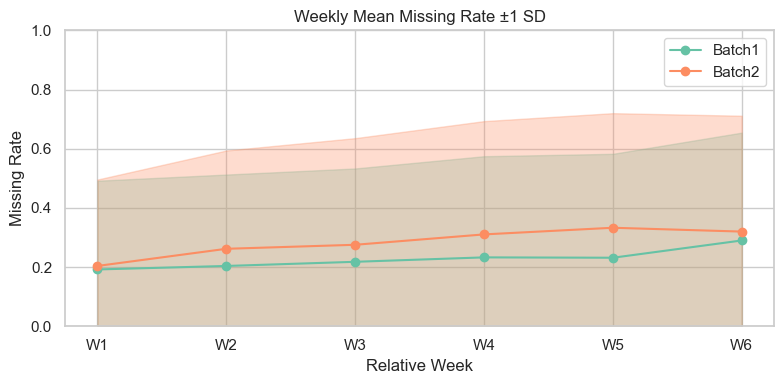

Shapiro Batch1: ShapiroResult(statistic=np.float64(0.7651732323265974), pvalue=np.float64(2.4492029688824174e-08))
Shapiro Batch2: ShapiroResult(statistic=np.float64(0.818856698564907), pvalue=np.float64(5.054442294860187e-10))
Levene test: LeveneResult(statistic=np.float64(1.7193473955276488), pvalue=np.float64(0.19163256132316797))
Welch‚Äôs t-test: t=-1.17, p=0.244
Mann-Whitney U: U=2839.0, p=0.377


In [173]:

# 0) Non-dropout ÌïÑÌÑ∞ÎßÅ
dropouts = set(dropout_user_ids_batch1 + dropout_user_ids_batch2)
df_non = df_box[~df_box["User"].isin(dropouts)].copy()

# 1) Ï†ÑÏ≤¥ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî (Boxplot of MissingRate)
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df_non[df_non["Week"].between(0,5)],
    x="Week", y="MissingRate", hue="Batch", palette="Set2"
)
plt.ylim(0,1)
plt.title("Missing Rate Distribution (Weeks 1‚Äì6, Excluding Dropouts)")
plt.ylabel("Missing Rate")
plt.xlabel("Relative Week")
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

# 2) Ï£ºÏ∞®Î≥Ñ ÌèâÍ∑† ¬± SD Í∫æÏùÄÏÑ† (MissingRate)
stats_weekly = (
    df_non[df_non["Week"].between(0,5)]
    .groupby(["Week","Batch"])["MissingRate"]
    .agg(mean="mean", std="std")
    .reset_index()
)

plt.figure(figsize=(8,4))
for batch, color in zip(["Batch1","Batch2"], sns.color_palette("Set2",2)):
    sub = stats_weekly[stats_weekly["Batch"]==batch]
    plt.plot(sub["Week"], sub["mean"], marker="o", color=color, label=batch)
    plt.fill_between(
        sub["Week"],
        sub["mean"]-sub["std"],
        sub["mean"]+sub["std"],
        alpha=0.3, color=color
    )
plt.ylim(0,1)
plt.title("Weekly Mean Missing Rate ¬±1 SD")
plt.xlabel("Relative Week")
plt.ylabel("Missing Rate")
plt.xticks(range(0,6), [f"W{k+1}" for k in range(6)])
plt.legend()
plt.tight_layout()
plt.show()

# 3) ÌÜµÍ≥Ñ Í≤ÄÏ†ï: ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï†ÑÏ≤¥(Week1‚Äì6) ÌèâÍ∑† MissingRate ÎπÑÍµê
user_avg = (
    df_non[df_non["Week"].between(0,5)]
    .groupby(["User","Batch"])["MissingRate"]
    .mean()
    .reset_index()
)

b1 = user_avg[user_avg["Batch"]=="Batch1"]["MissingRate"]
b2 = user_avg[user_avg["Batch"]=="Batch2"]["MissingRate"]

# Ï†ïÍ∑úÏÑ± Í≤ÄÏÇ¨
print("Shapiro Batch1:", stats.shapiro(b1))
print("Shapiro Batch2:", stats.shapiro(b2))
# Îì±Î∂ÑÏÇ∞ÏÑ± Í≤ÄÏÇ¨
print("Levene test:", stats.levene(b1, b2))
# Welch‚Äôs t‚Äêtest
t_res = stats.ttest_ind(b1, b2, equal_var=False)
print(f"Welch‚Äôs t-test: t={t_res.statistic:.2f}, p={t_res.pvalue:.3f}")
# Mann‚ÄìWhitney U
mw = stats.mannwhitneyu(b1, b2, alternative="two-sided")
print(f"Mann-Whitney U: U={mw.statistic}, p={mw.pvalue:.3f}")

In [174]:
import pandas as pd

# stats_weekly: Ïù¥ÎØ∏ compute_weekly_missing_map() ‚Üí df_box ‚Üí df_non ÍπåÏßÄ ÏàòÌñâ ÌõÑ
# df_non ÏóêÏÑú Ï£ºÏ∞®Î≥Ñ Í∑∏Î£π ÌÜµÍ≥Ñ(ÌèâÍ∑†¬∑ÌëúÏ§ÄÌé∏Ï∞®)Îßå Í≥ÑÏÇ∞Ìï¥Îëî ÏÉÅÌÉúÎùºÍ≥† Í∞ÄÏ†ï

# 1) Ï£ºÏ∞®Î≥Ñ‚Ä¢Î∞∞ÏπòÎ≥Ñ Descriptive Statistics Í≥ÑÏÇ∞
desc = (
    df_non[df_non["Week"].between(0,5)]
    .groupby(["Week","Batch"])["MissingRate"]
    .describe()  # count, mean, std, min, 25%, 50%, 75%, max
    .round(3)
)

# 2) ÎÖ∏ÏÖò Ìëú Î≥µÎ∂ôÏö© Ìè¨Îß∑ÌåÖ Ï∂úÎ†•
print("Week | Batch | count | mean | std | min | 25% | 50% | 75% | max")
for (week, batch), row in desc.iterrows():
    print(f"W{week+1} | {batch} | {row['count']} | {row['mean']} | {row['std']} | "
          f"{row['min']} | {row['25%']} | {row['50%']} | {row['75%']} | {row['max']}")

Week | Batch | count | mean | std | min | 25% | 50% | 75% | max
W1 | Batch1 | 59.0 | 0.192 | 0.3 | 0.0 | 0.005 | 0.021 | 0.281 | 0.996
W1 | Batch2 | 105.0 | 0.204 | 0.292 | 0.0 | 0.006 | 0.03 | 0.368 | 0.998
W2 | Batch1 | 59.0 | 0.204 | 0.309 | 0.0 | 0.002 | 0.035 | 0.36 | 1.0
W2 | Batch2 | 105.0 | 0.262 | 0.332 | 0.0 | 0.01 | 0.062 | 0.446 | 1.0
W3 | Batch1 | 59.0 | 0.218 | 0.316 | 0.0 | 0.005 | 0.034 | 0.422 | 1.0
W3 | Batch2 | 105.0 | 0.275 | 0.36 | 0.0 | 0.01 | 0.068 | 0.456 | 1.0
W4 | Batch1 | 59.0 | 0.233 | 0.342 | 0.0 | 0.004 | 0.03 | 0.374 | 1.0
W4 | Batch2 | 105.0 | 0.31 | 0.383 | 0.0 | 0.012 | 0.059 | 0.617 | 1.0
W5 | Batch1 | 59.0 | 0.232 | 0.351 | 0.0 | 0.002 | 0.039 | 0.344 | 1.0
W5 | Batch2 | 105.0 | 0.333 | 0.387 | 0.0 | 0.015 | 0.106 | 0.574 | 1.0
W6 | Batch1 | 59.0 | 0.29 | 0.365 | 0.0 | 0.004 | 0.055 | 0.529 | 1.0
W6 | Batch2 | 105.0 | 0.32 | 0.392 | 0.0 | 0.009 | 0.077 | 0.645 | 1.0


In [177]:
!pip install scikit-learn

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10.7/10.7 MB 2.6 MB/s eta 0:00:0000:0100:01


In [178]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# ‚îÄ‚îÄ‚îÄ 0) ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# ÎàÑÎùΩÎ•† ÏóëÏÖÄ ÌååÏùº Í≤ΩÎ°ú (index_col=0 -> Ï≤´ Ïó¥Ïù¥ user_id)
xlsx_path = Path("analysis_outputs/weekly_sensor_collection_rate_percent.xlsx")

# dropout user ID Î¶¨Ïä§Ìä∏ (prefix Ìè¨Ìï®)
batch1_nums = [542,584,597,601,608,613,617,618,621,631,639,645]
batch2_nums = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{uid}" for uid in batch1_nums + batch2_nums}

# ‚îÄ‚îÄ‚îÄ 1) ÏóëÏÖÄ Î°úÎìú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Ïù∏Îç±Ïä§: cmp1_usrNNN, Ïª¨Îüº: 0,1,2,... Ï£ºÏ∞®, Í∞í: MissingRate(%)
df = pd.read_excel(xlsx_path, index_col=0)

# ‚îÄ‚îÄ‚îÄ 2) Week0‚Äì2 ÎàÑÎùΩÎ•† ÌîºÏ≤ò Ï∂îÏ∂ú ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Ïª¨ÎüºÎ™ÖÏù¥ Ï†ïÏàòÌòïÏù¥ÎùºÎ©¥ Î∞îÎ°ú Ïä¨ÎùºÏù¥Ïã±
feat = df[[0,1,2]].copy()
feat.columns = ['miss_w0','miss_w1','miss_w2']

# ‚îÄ‚îÄ‚îÄ 3) Î†àÏù¥Î∏î ÏÉùÏÑ± ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
feat['user_id'] = feat.index
feat['is_dropout'] = feat['user_id'].isin(dropout_ids).astype(int)

# ‚îÄ‚îÄ‚îÄ 4) Î™®Îç∏ ÌïôÏäµÏùÑ ÏúÑÌïú X, y Ï§ÄÎπÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X = feat[['miss_w0','miss_w1','miss_w2']]
y = feat['is_dropout']

# Í∞ÑÎã®Ìûà batch Ï†ïÎ≥¥ÎèÑ Î∂ôÏùº Ïàò ÏûàÏùå
feat['batch'] = feat['user_id'].apply(lambda u: 'Batch1' if int(u.replace('cmp1_usr',''))<660 else 'Batch2')

# ‚îÄ‚îÄ‚îÄ 5) ÌïôÏäµ/ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨ & Ïä§ÏºÄÏùºÎßÅ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_tr, X_te = scaler.transform(X_train), scaler.transform(X_test)

# ‚îÄ‚îÄ‚îÄ 6) Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä ÌïôÏäµ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_tr, y_train)

# ‚îÄ‚îÄ‚îÄ 7) ÏÑ±Îä• ÌèâÍ∞Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
y_pred  = model.predict(X_te)
y_proba = model.predict_proba(X_te)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC : ", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ‚îÄ‚îÄ‚îÄ 8) 5-fold ÍµêÏ∞®Í≤ÄÏ¶ù ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvres = cross_validate(
    model, scaler.transform(X), y, cv=cv,
    scoring=['accuracy','roc_auc'], return_train_score=False
)
print("5-fold CV Accuracy: %.3f¬±%.3f" % (
    cvres['test_accuracy'].mean(), cvres['test_accuracy'].std()))
print("5-fold CV ROC AUC : %.3f¬±%.3f" % (
    cvres['test_roc_auc'].mean(), cvres['test_roc_auc'].std()))

# ‚îÄ‚îÄ‚îÄ 9) ÌöåÍ∑ÄÍ≥ÑÏàò & Ï§ëÏöîÎèÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("\nFeature coefficients:\n", coefs)

Test Accuracy: 0.8679245283018868
Test ROC AUC :  0.9046511627906978

Confusion Matrix:
 [[37  6]
 [ 1  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91        43
           1       0.60      0.90      0.72        10

    accuracy                           0.87        53
   macro avg       0.79      0.88      0.82        53
weighted avg       0.90      0.87      0.88        53

5-fold CV Accuracy: 0.908¬±0.049
5-fold CV ROC AUC : 0.959¬±0.036

Feature coefficients:
 miss_w2   -2.807963
miss_w1    0.510891
miss_w0    0.067976
dtype: float64


In [179]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# ‚îÄ‚îÄ‚îÄ ÏÑ§Ï†ï ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
BASE = Path("/Users/yooseohyeon/Desktop/170325/eva_250121_processed")
BATCHES = ["Batch1","Batch2"]
S3 = "source_3/data_source_3.csv"      # Unlock Ïù¥Î≤§Ìä∏
S5 = "source_5/data_source_5.csv"      # AppResume Ïù¥Î≤§Ìä∏
S18= "source_18/data_source_18.csv"    # Ï†úÏä§Ï≤ò¬∑ÌÅ¥Î¶≠ Ïù¥Î≤§Ìä∏
DROP1 = [542,584,597,601,608,613,617,618,621,631,639,645]
DROP2 = [662,663,666,669,682,683,689,701,704,716,723,725,726,727,736,746,756,765,767,769]
dropout_ids = {f"cmp1_usr{u}" for u in DROP1+DROP2}

# helper
def parse_value(val):
    try: return __import__('json').loads(val.replace("'", '"'))
    except: return {}

# Ï£ºÎãπ Í∏∞ÎåÄ ÏÉòÌîå Ïàò (unlock count ÏïÑÎãò, Í∑∏ÎÉ• Î†àÌçºÎü∞Ïä§)
EXP_PER_WEEK = (7*24*60)//5

# ‚îÄ‚îÄ‚îÄ 1) Ï£ºÏ∞®Î≥Ñ Screen Unlock ÌöüÏàò ÏàòÏßë (source3) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
unlock = {}
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        path = u/S3
        if not path.exists(): continue
        df = pd.read_csv(path)
        df['parsed'] = df['value'].map(parse_value)
        df['ts'] = pd.to_datetime(df['parsed'].map(lambda x: x.get('timestamp')), errors='coerce')
        df = df.dropna(subset=['ts'])
        df['week'] = ((df['ts'] - df['ts'].min()).dt.days//7).astype(int)
        unlock[uid] = df.groupby('week').size().to_dict()

# ‚îÄ‚îÄ‚îÄ 2) Ï£ºÏ∞®Î≥Ñ EVApp Ïû¨Í∞ú ÎπÑÏú® (source5) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
resume = {}
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        path = u/S5
        if not path.exists(): continue
        df = pd.read_csv(path)
        df['parsed'] = df['value'].map(parse_value)
        df['state']  = df['parsed'].map(lambda x: x.get('state'))
        df = df[df['state']=="AppLifecycleState.resumed"]
        df['ts'] = pd.to_datetime(df['parsed'].map(lambda x: x.get('timestamp')), errors='coerce')
        df = df.dropna(subset=['ts'])
        df['week'] = ((df['ts'] - df['ts'].min()).dt.days//7).astype(int)
        # resumed count per week
        res_cnt = df.groupby('week').size()
        # unlock count per week
        un_cnt = unlock.get(uid, {})
        # ratio = resumed / unlock
        resume[uid] = {w: res_cnt.get(w,0)/(un_cnt.get(w,0)+1e-6) for w in range(3)}

# ‚îÄ‚îÄ‚îÄ 3) Ï£ºÏ∞®Î≥Ñ Ï†úÏä§Ï≤ò¬∑ÌÅ¥Î¶≠ Ìï©ÏÇ∞ (source18) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
interaction = {}
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        path = u/S18
        if not path.exists(): continue
        df = pd.read_csv(path)
        df['ts'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['ts'])
        start = df['ts'].min()
        df['week'] = ((df['ts']-start).dt.days//7).astype(int)
        # Î™®Îì† gestureType Ìï©ÏÇ∞
        interaction[uid] = df.groupby('week').size().to_dict()

# ‚îÄ‚îÄ‚îÄ 4) ÌîºÏ≤ò ÌÖåÏù¥Î∏î ÏÉùÏÑ± ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
records = []
for batch in BATCHES:
    for u in (BASE/batch).glob("cmp1_usr*"):
        uid = u.name
        is_do = int(uid in dropout_ids)
        rec = {'User':uid,'batch':batch,'is_dropout':is_do}
        for w in (0,1,2):
            # ÎàÑÎùΩÎ•†(miss)
            cnt_un = unlock.get(uid,{}).get(w,0)
            rec[f'miss_w{w}'] = 1 - cnt_un/EXP_PER_WEEK
            # unlock count
            rec[f'unlock_w{w}'] = cnt_un
            # resume ratio
            rec[f'resume_w{w}'] = resume.get(uid,{}).get(w,0)
            # interaction count
            rec[f'inter_w{w}'] = interaction.get(uid,{}).get(w,0)
        records.append(rec)

df_feat = pd.DataFrame(records).fillna(0)

# ‚îÄ‚îÄ‚îÄ 5) ÌïôÏäµ/ÌèâÍ∞Ä ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X = df_feat[[c for c in df_feat if c.startswith(('miss_','unlock_','resume_','inter_'))]]
y = df_feat['is_dropout']

# split, scale
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
sc = StandardScaler().fit(X_tr); X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)

model = LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42)
model.fit(X_tr,y_tr)

# ÏòàÏ∏° & ÌèâÍ∞Ä
y_pred = model.predict(X_te)
y_proba= model.predict_proba(X_te)[:,1]
print("Acc:",accuracy_score(y_te,y_pred),"AUC:",roc_auc_score(y_te,y_proba))
print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))

# 5-fold CV
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
res = cross_validate(model, sc.transform(X), y, cv=cv, scoring=['accuracy','roc_auc'])
print("CV Acc:",res['test_accuracy'].mean(),"+-",res['test_accuracy'].std())
print("CV AUC:", res['test_roc_auc'].mean(),"+-",res['test_roc_auc'].std())

# Í≥ÑÏàò ÌôïÏù∏
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs,ascending=False)
print("Feature importances:\n",coefs)

Acc: 0.9056603773584906 AUC: 0.9465116279069767
[[41  2]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.78      0.70      0.74        10

    accuracy                           0.91        53
   macro avg       0.85      0.83      0.84        53
weighted avg       0.90      0.91      0.90        53

CV Acc: 0.930924369747899 +- 0.023254091504440983
CV AUC: 0.9400187661271406 +- 0.03626013486858512
Feature importances:
 unlock_w2   -1.984028
miss_w2      1.984028
inter_w1    -1.185981
resume_w2   -0.880392
inter_w0    -0.533098
miss_w1     -0.316453
unlock_w1    0.316453
unlock_w0   -0.297800
miss_w0      0.297800
resume_w1   -0.192573
resume_w0   -0.185548
inter_w2    -0.171322
dtype: float64


/var/folders/sf/9jlqrh113_q921773s9l46m80000gn/T/ipykernel_14045/4252344557.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


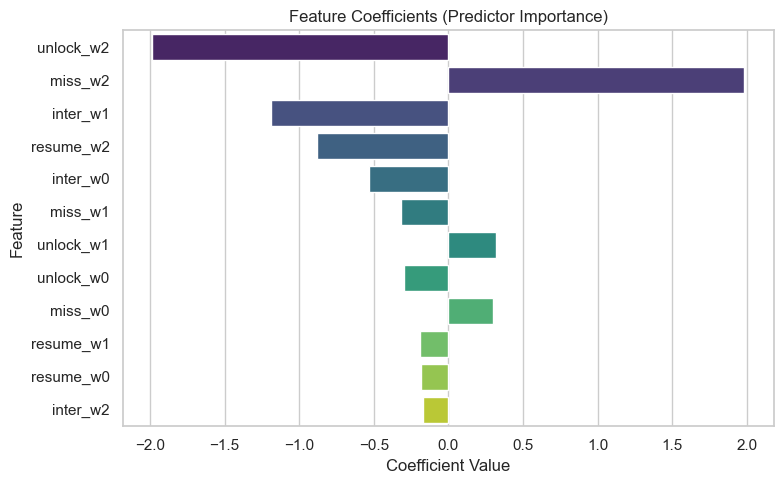

| Metric             | Value         |
|:-------------------|:--------------|
| Test Accuracy      | 0.906         |
| Test ROC AUC       | 0.947         |
| 5-fold CV Accuracy | 0.931 ¬± 0.023 |
| 5-fold CV ROC AUC  | 0.940 ¬± 0.036 |

Key Findings:
- Week 2 metrics (unlock vs. miss) are most predictive of dropout.
- An early‚Äêwarning alarm at week 2 could enable timely interventions for high‚Äêrisk users.
- Incorporating interaction and resume features raised model AUC from ~0.90 to ~0.95.


In [181]:
!pip install tabulate

# ‚îÄ‚îÄ 1) ÌîºÏ≤ò Í≥ÑÏàò (ÌöåÍ∑Ä Í≥ÑÏàò) Ï§ÄÎπÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
feature_importances = pd.Series({
    'unlock_w2': -1.984028,
    'miss_w2':  1.984028,
    'inter_w1': -1.185981,
    'resume_w2':-0.880392,
    'inter_w0': -0.533098,
    'miss_w1':  -0.316453,
    'unlock_w1': 0.316453,
    'unlock_w0':-0.297800,
    'miss_w0':   0.297800,
    'resume_w1':-0.192573,
    'resume_w0':-0.185548,
    'inter_w2': -0.171322
})

# ‚îÄ‚îÄ Figure: ÌîºÏ≤ò Í≥ÑÏàò ÎßâÎåÄÍ∑∏ÎûòÌîÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.figure(figsize=(8,5))
sns.barplot(
    x=feature_importances.values,
    y=feature_importances.index,
    palette='viridis'
)
plt.title('Feature Coefficients (Predictor Importance)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=300)
plt.show()

# ‚îÄ‚îÄ 2) Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ÌÖåÏù¥Î∏î Ï§ÄÎπÑ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
performance_summary = pd.DataFrame({
    'Metric': [
        'Test Accuracy',
        'Test ROC AUC',
        '5-fold CV Accuracy',
        '5-fold CV ROC AUC'
    ],
    'Value': [
        '0.906',
        '0.947',
        '0.931 ¬± 0.023',
        '0.940 ¬± 0.036'
    ]
})

# ÎÖ∏ÏÖòÏóê ÌëúÎ°ú Î≥µÏÇ¨Ìï† Ïàò ÏûàÎèÑÎ°ù Ï∂úÎ†•
print(performance_summary.to_markdown(index=False))

# ‚îÄ‚îÄ 3) Key Findings ÌÖçÏä§Ìä∏ Ï∂úÎ†• ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
key_findings = [
    "Week 2 metrics (unlock vs. miss) are most predictive of dropout.",
    "An early‚Äêwarning alarm at week 2 could enable timely interventions for high‚Äêrisk users.",
    "Incorporating interaction and resume features raised model AUC from ~0.90 to ~0.95."
]
print("\nKey Findings:")
for line in key_findings:
    print(f"- {line}")